In [1]:
# Preprocessing
from sklearn import preprocessing
import xgboost as xgb

# modules to handle data
import os
import pandas as pd
import numpy as np
import seaborn as sns
import csv
import pickle
import gc

%matplotlib inline
import matplotlib.pyplot as plt

# Create submission file with assigned predicted results from models
def create_file_for_submission(filename, classifier_predictions):
    kaggle_submission = pd.read_csv('./datasets/IEEEFraudDetection/sample_submission.csv', index_col='TransactionID')

    # Probabilities of class 2 ('isFraud'=1) is in column 1 of the matrix
    kaggle_submission['isFraud'] = classifier_predictions[:,1]
    kaggle_submission.to_csv(filename)
    
def load_classifier_from_picklefile(filename):
    infile = open(filename,'rb')
    loaded_Classifier = pickle.load(infile)
    infile.close()
    return loaded_Classifier
    
def save_classifier_to_picklefile(filename, save_Classifier):
    model_file = open(filename,'wb')
    pickle.dump(save_Classifier, model_file)
    model_file.close()

In [2]:
# load data 
train_identity = pd.read_csv('./datasets/IEEEFraudDetection/train_identity.csv', index_col='TransactionID')
train_transaction = pd.read_csv('./datasets/IEEEFraudDetection/train_transaction.csv', index_col='TransactionID')

test_identity = pd.read_csv('./datasets/IEEEFraudDetection/test_identity.csv', index_col='TransactionID')
test_transaction = pd.read_csv('./datasets/IEEEFraudDetection/test_transaction.csv', index_col='TransactionID')

In [3]:
# train_transaction.head(), train_identity.head()
# test_identity.head(), test_transaction.head()
print("Shape of train_identity : ", train_identity.shape)
print("Shape of train_transaction : ", train_transaction.shape)
print("Shape of test_identity : ", test_identity.shape)
print("Shape of test_transaction : ", test_transaction.shape)

Shape of train_identity :  (144233, 40)
Shape of train_transaction :  (590540, 393)
Shape of test_identity :  (141907, 40)
Shape of test_transaction :  (506691, 392)


In [4]:
train_merged = train_transaction.merge(train_identity,
                                       how='left', left_index=True, right_index=True)
test_merged = test_transaction.merge(test_identity,
                                     how='left',left_index=True, right_index=True)

print("Shape of train_merged_identity : ", train_merged.shape)
print("Shape of train_merged_transaction : ", test_merged.shape)

Shape of train_merged_identity :  (590540, 433)
Shape of train_merged_transaction :  (506691, 432)


# Transaction columns (394 items including 'TransactionID')

1. TransactionID, isFraud, TransactionDT, TransactionAmt, ProductCD,
2. card1 - card6,
3. addr1 - addr2,
4. dist1 - dist2,
5. P_emaildomain, R_emaildomain,
6. C1 - C14,
7. D1 - D15,
8. M1 - M9,
9. V1 - V339

# Identity columns (41 items including 'TransactionID')
1. TransactionID,
2. id_01 - id_38,
3. DeviceType, DeviceInfo

In [5]:
# test_merged[19900:19910]
print("Merged DataFrame shape :", train_merged.shape)
train_merged.head()

Merged DataFrame shape : (590540, 433)


,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [6]:
imputer_list = ['D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'addr1', 'addr2']

train_merged[imputer_list].head(10)

,D6,D7,D8,D9,D10,D11,D12,D13,D14,addr1,addr2
TransactionID,,,,,,,,,,,
2987000,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,315.0,87.0
2987001,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,325.0,87.0
2987002,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,330.0,87.0
2987003,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,476.0,87.0
2987004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,420.0,87.0
2987005,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,272.0,87.0
2987006,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,126.0,87.0
2987007,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,325.0,87.0
2987008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,337.0,87.0


In [7]:
from sklearn.impute import SimpleImputer

# D11               47.29%
# D10               12.87%
# Imputation for missing values with mean values
mean_imputer = SimpleImputer()

for col_name in imputer_list:
    tmp_pd = pd.DataFrame(mean_imputer.fit_transform(pd.DataFrame(train_merged[col_name])).astype(int))
    tmp_pd.index = train_merged.index
    train_merged[col_name] = tmp_pd

train_merged[imputer_list].head(10)

,D6,D7,D8,D9,D10,D11,D12,D13,D14,addr1,addr2
TransactionID,,,,,,,,,,,
2987000,69,41,146,0,13,13,54,17,57,315,87
2987001,69,41,146,0,0,146,54,17,57,325,87
2987002,69,41,146,0,0,315,54,17,57,330,87
2987003,69,41,146,0,84,146,54,17,57,476,87
2987004,69,41,146,0,123,146,54,17,57,420,87
2987005,69,41,146,0,0,0,54,17,57,272,87
2987006,69,41,146,0,0,0,54,17,57,126,87
2987007,69,41,146,0,0,146,54,17,57,325,87
2987008,69,41,146,0,123,146,54,17,57,337,87


In [8]:
X_transformed = pd.DataFrame(mean_imputer.fit_transform(pd.DataFrame(train_merged[imputer_list])).astype(float))

X_transformed.index = train_merged.index

train_merged[imputer_list].head(10)

,D6,D7,D8,D9,D10,D11,D12,D13,D14,addr1,addr2
TransactionID,,,,,,,,,,,
2987000,69,41,146,0,13,13,54,17,57,315,87
2987001,69,41,146,0,0,146,54,17,57,325,87
2987002,69,41,146,0,0,315,54,17,57,330,87
2987003,69,41,146,0,84,146,54,17,57,476,87
2987004,69,41,146,0,123,146,54,17,57,420,87
2987005,69,41,146,0,0,0,54,17,57,272,87
2987006,69,41,146,0,0,0,54,17,57,126,87
2987007,69,41,146,0,0,146,54,17,57,325,87
2987008,69,41,146,0,123,146,54,17,57,337,87


# Categorical Features - Transaction
1. ProductCD
2. card1 - card6
3. addr1, addr2
4. P_emaildomain
5. R_emaildomain
6. M1 - M9

# Categorical Features - Identity
7. DeviceType
8. DeviceInfo
9. id_12 - id_38<BR>
<BR>** The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp). **

### <B>1. ProductCD</B>

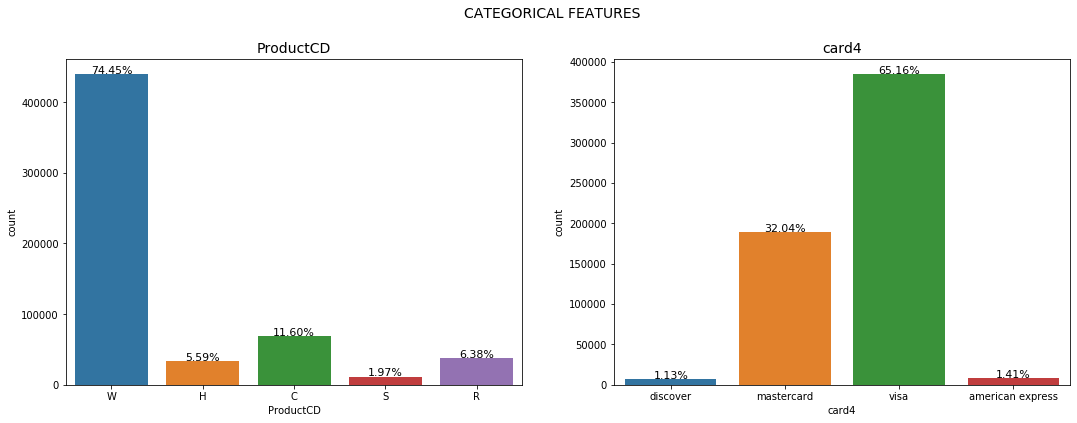

Missing Data for ProductCD :0.00%
Missing Data for card 3 :0.27%


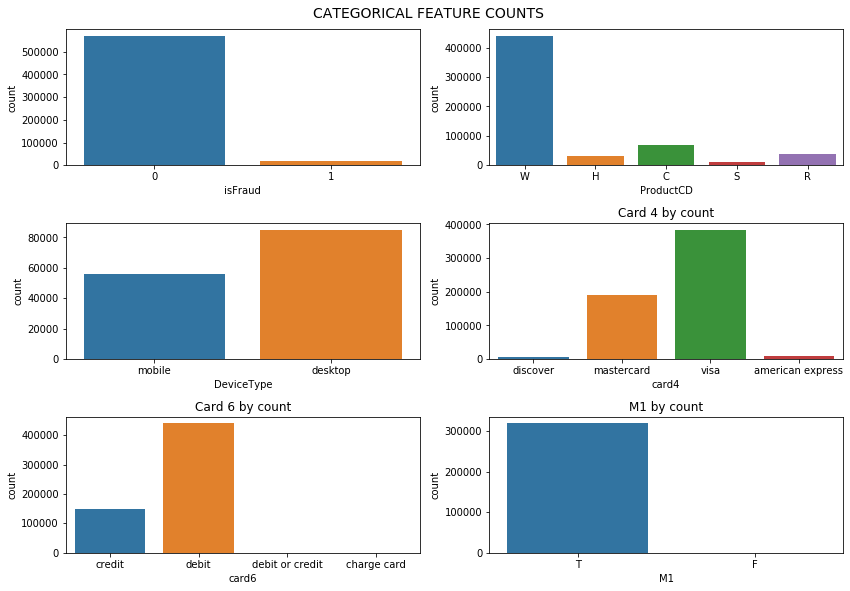

In [9]:
# Initialized variables
total_counts = len(train_merged)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
fig.suptitle('Categorical Features'.upper(), y=1.0, fontsize=14)

df_dType = pd.DataFrame({'ProductCD' : train_merged['ProductCD']})
df_id12 = pd.DataFrame({'id_12' : train_merged['id_12']})
#df_dType['ProductCD'] = df_dType['ProductCD'].fillna(-999)

ProductCD = sns.countplot(x='ProductCD', data=df_dType, ax=axes[0])
ProductCD.set_title('ProductCD', fontsize=14)
for rectBox in ProductCD.patches:
    count = rectBox.get_height()
    #print("ProductCD Counts :", count)
    
    ProductCD.text(rectBox.get_x() + rectBox.get_width()/2.,
                   count + 1000,
                   '{:1.2f}%'.format(count/total_counts*100),
                   ha="center", fontsize=11)

#print("----------------------------------------")
Card4 = sns.countplot(x=train_merged['card4'], data=train_merged, ax=axes[1])
Card4.set_title('card4', fontsize=14)
for rectBox in Card4.patches:
    count = rectBox.get_height()
    #print("Card4 Counts :", count)
    
    Card4.text(rectBox.get_x() + rectBox.get_width()/2.,
               count + 1000,
               '{:1.2f}%'.format(count/total_counts*100),
               ha="center", fontsize=11)

# Eg. To change the x-labels
# plt.xticks(np.arange(3), ("Missing", "Yes", "No"))
plt.show()

print("Missing Data for ProductCD :" + '{:1.2f}%'.format(train_merged['ProductCD'].isnull().sum() / total_counts * 100))
print("Missing Data for card 3 :" + '{:1.2f}%'.format(train_merged['card3'].isnull().sum() / total_counts * 100))


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))
fig.subplots_adjust(hspace=1.0)
fig.suptitle('Categorical Feature counts'.upper(), y=1.02, fontsize=14)

isFraud = sns.countplot(x=train_merged['isFraud'], data=train_merged, ax=axes[0][0])
ProductCD = sns.countplot(x=train_merged['ProductCD'], data=train_merged, ax=axes[0][1])
DeviceType = sns.countplot(x=train_merged['DeviceType'], data=train_merged, ax=axes[1][0])

card4 = sns.countplot(x=train_merged['card4'], data=train_merged,ax=axes[1][1]).set_title("Card 4 by count")
card6 = sns.countplot(x=train_merged['card6'], data=train_merged, ax=axes[2][0]).set_title("Card 6 by count")
m1 = sns.countplot(x=train_merged['M1'], data=train_merged, ax=axes[2][1]).set_title("M1 by count")

plt.tight_layout()

### <B>2. card4 and card6</B>
(Missing Data : 0.27%)

In [10]:
c_cols = [c for c in train_merged if c[0] == 'c']

# Example : train_merged['id_01'].value_counts()
for ctr in range(len(c_cols)):
    col_name = c_cols[ctr]
    df_unique = train_merged[col_name].nunique()
    df_unique_counts = train_merged[col_name].value_counts()
    print ("No. of unique values in", col_name, " :", df_unique)
    #print ("No. of counts per unique value in", col_name, " :\n", df_unique_counts)
    print("Missing Data : " + '{:1.2f}%'.format(train_merged[col_name].isnull().sum() / total_counts * 100))
    
train_merged[c_cols].head()

No. of unique values in card1  : 13553
Missing Data : 0.00%
No. of unique values in card2  : 500
Missing Data : 1.51%
No. of unique values in card3  : 114
Missing Data : 0.27%
No. of unique values in card4  : 4
Missing Data : 0.27%
No. of unique values in card5  : 119
Missing Data : 0.72%
No. of unique values in card6  : 4
Missing Data : 0.27%


,card1,card2,card3,card4,card5,card6
TransactionID,,,,,,
2987000,13926,NaN,150.0,discover,142.0,credit
2987001,2755,404.0,150.0,mastercard,102.0,credit
2987002,4663,490.0,150.0,visa,166.0,debit
2987003,18132,567.0,150.0,mastercard,117.0,debit
2987004,4497,514.0,150.0,mastercard,102.0,credit


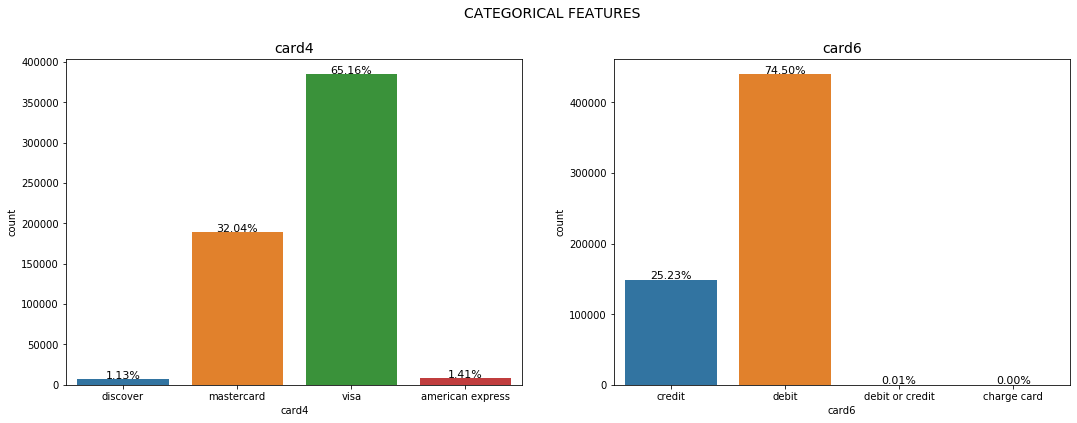

Missing Data for card 4 :0.27%
Missing Data for card 6 :0.27%


In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
fig.suptitle('Categorical Features'.upper(), y=1.0, fontsize=14)
df_card4 = pd.DataFrame({'card4' : train_merged['card4']})
df_card6 = pd.DataFrame({'card4' : train_merged['card6']})

#df_dType['ProductCD'] = df_dType['ProductCD'].fillna(-999)

Card4 = sns.countplot(x=train_merged['card4'], data=train_merged, ax=axes[0])
Card4.set_title('card4', fontsize=14)
for rectBox in Card4.patches:
    count = rectBox.get_height()
    #print("Card4 Counts :", count)
    
    Card4.text(rectBox.get_x() + rectBox.get_width()/2.,
               count + 1000,
               '{:1.2f}%'.format(count/total_counts*100),
               ha="center", fontsize=11)

#print("----------------------------------------")
Card6 = sns.countplot(x=train_merged['card6'], data=train_merged, ax=axes[1])
Card6.set_title('card6', fontsize=14)
for rectBox in Card6.patches:
    count = rectBox.get_height()
    #print("Card6 Counts :", count)
    
    Card6.text(rectBox.get_x() + rectBox.get_width()/2.,
               count + 1000,
               '{:1.2f}%'.format(count/total_counts*100),
               ha="center", fontsize=11)

# Eg. To change the x-labels
# plt.xticks(np.arange(3), ("Missing", "Yes", "No"))
plt.show()

print("Missing Data for card 4 :" + '{:1.2f}%'.format(train_merged['card4'].isnull().sum() / total_counts * 100))
print("Missing Data for card 6 :" + '{:1.2f}%'.format(train_merged['card6'].isnull().sum() / total_counts * 100))

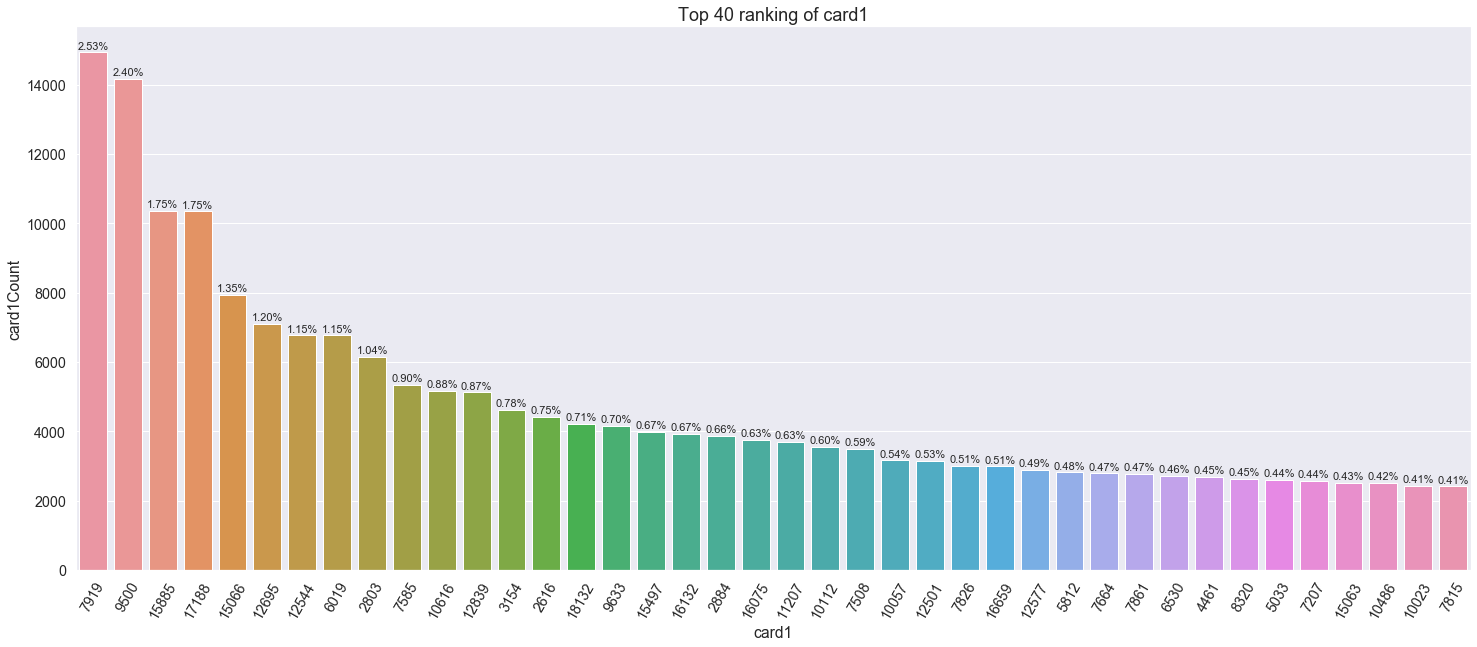

Total no. of card1 : 13553
Missing Data for card1 : 0.00%
Top 40 :
 card1
7919      7919
9500      9500
15885    15885
17188    17188
15066    15066
12695    12695
12544    12544
6019      6019
2803      2803
7585      7585
10616    10616
12839    12839
3154      3154
2616      2616
18132    18132
9633      9633
15497    15497
16132    16132
2884      2884
16075    16075
11207    11207
10112    10112
7508      7508
10057    10057
12501    12501
7826      7826
16659    16659
12577    12577
5812      5812
7664      7664
7861      7861
6530      6530
4461      4461
8320      8320
5033      5033
7207      7207
15063    15063
10486    10486
10023    10023
7815      7815
Name: card1, dtype: int64


In [12]:
card1_Grp = pd.DataFrame()
card1_Grp['card1Count'] = train_merged.groupby(['card1'])['card1'].count()
card1_Grp['card1'] = card1_Grp.index
topmost = 40

# There are too many card1, so we will subset the top group
card1_grp_top = card1_Grp.sort_values(by='card1Count',ascending=False).head(topmost)
order_card1 = card1_grp_top.sort_values(by='card1Count',ascending=False)['card1']

plt.figure(figsize=(25, 10))
sns.set(color_codes=True)
sns.set(font_scale = 1.3)
ax = sns.barplot(x='card1', y='card1Count', data=card1_grp_top, order=order_card1)
ax.set_title('Top ' + str(topmost) + ' ranking of card1', fontsize=18)
for rectBox in ax.patches:
    count = rectBox.get_height()
    #print("Counts :", count)    
    ax.text(rectBox.get_x() + rectBox.get_width()/2.,
            count + 100,
            '{:1.2f}%'.format(count/total_counts*100),
            ha="center", fontsize=11)


xt = plt.xticks(rotation=60)
plt.show()

print("Total no. of card1 :", len(card1_Grp.index))
print("Missing Data for card1 : " +
      '{:1.2f}%'.format(train_merged['card1'].isnull().sum() / total_counts * 100))
print("Top " + str(topmost) + " :\n", card1_grp_top['card1'])

for ctr in range(len(card1_grp_top)):
    if (card1_grp_top.iloc[ctr]['card1'] == -999):
        print("Found in Index", str(ctr) + ":", card1_grp_top.iloc[ctr]['card1Count'])
        print("Missing Data : " + '{:1.2f}%'.format(card1_grp_top.iloc[ctr]['card1Count'] / total_counts * 100))

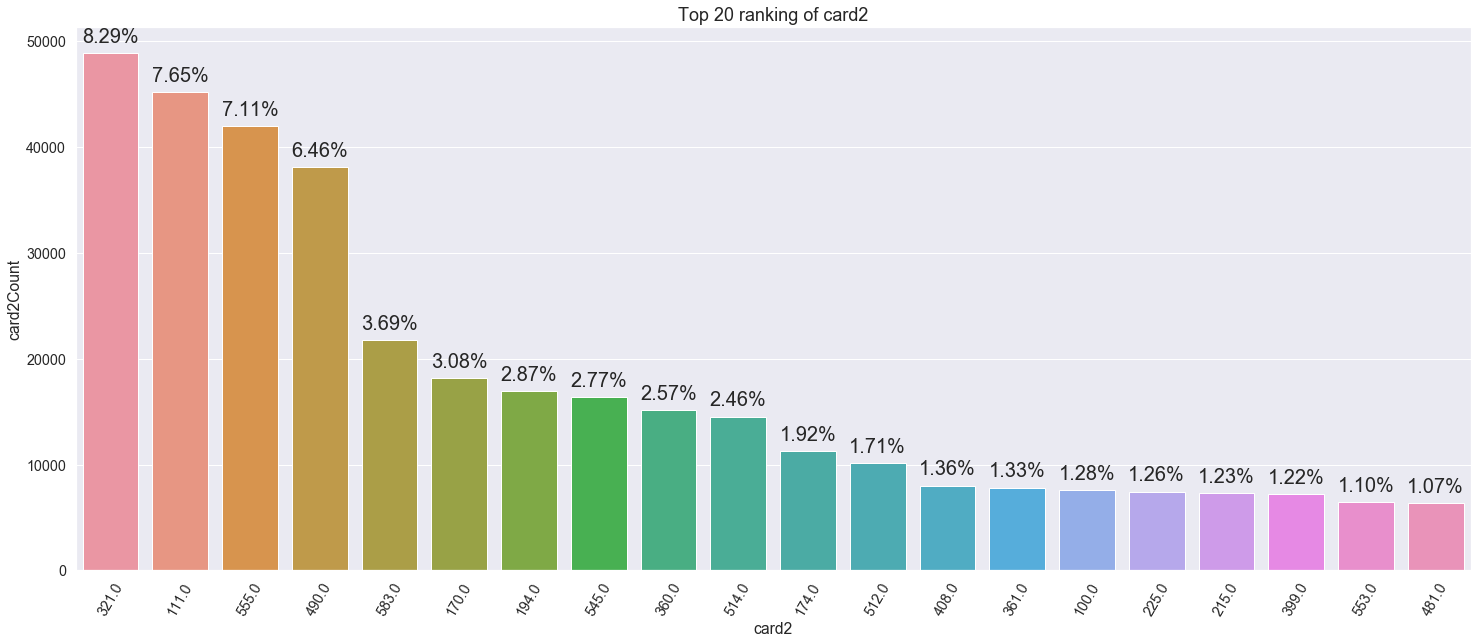

Total no. of card2 : 500
Missing Data for card2 : 1.51%
Top 20 :
 card2
321.0    321.0
111.0    111.0
555.0    555.0
490.0    490.0
583.0    583.0
170.0    170.0
194.0    194.0
545.0    545.0
360.0    360.0
514.0    514.0
174.0    174.0
512.0    512.0
408.0    408.0
361.0    361.0
100.0    100.0
225.0    225.0
215.0    215.0
399.0    399.0
553.0    553.0
481.0    481.0
Name: card2, dtype: float64


In [13]:
card2_Grp = pd.DataFrame()
card2_Grp['card2Count'] = train_merged.groupby(['card2'])['card2'].count()
card2_Grp['card2'] = card2_Grp.index

# There are too many Devices, so we will subset the top 20
card2_grp_top = card2_Grp.sort_values(by='card2Count',ascending=False).head(20)
order_card2 = card2_grp_top.sort_values(by='card2Count',ascending=False)['card2']

plt.figure(figsize=(25, 10))
sns.set(color_codes=True)
sns.set(font_scale = 1.3)
ax = sns.barplot(x='card2', y='card2Count', data=card2_grp_top, order=order_card2)
ax.set_title('Top 20 ranking of card2', fontsize=18)
for rectBox in ax.patches:
    count = rectBox.get_height()
    #print("Counts :", count)    
    ax.text(rectBox.get_x() + rectBox.get_width()/2.,
            count + 1000,
            '{:1.2f}%'.format(count/total_counts*100),
            ha="center", fontsize=20)


xt = plt.xticks(rotation=60)
plt.show()

print("Total no. of card2 :", len(card2_Grp.index))
print("Missing Data for card2 : " +
      '{:1.2f}%'.format(train_merged['card2'].isnull().sum() / total_counts * 100))
print("Top 20 :\n", card2_grp_top['card2'])

for ctr in range(len(card2_grp_top)):
    if (card2_grp_top.iloc[ctr]['card2'] == -999):
        print("Found in Index", str(ctr) + ":", card2_grp_top.iloc[ctr]['card2Count'])
        print("Missing Data : " + '{:1.2f}%'.format(card2_grp_top.iloc[ctr]['card2Count'] / total_counts * 100))

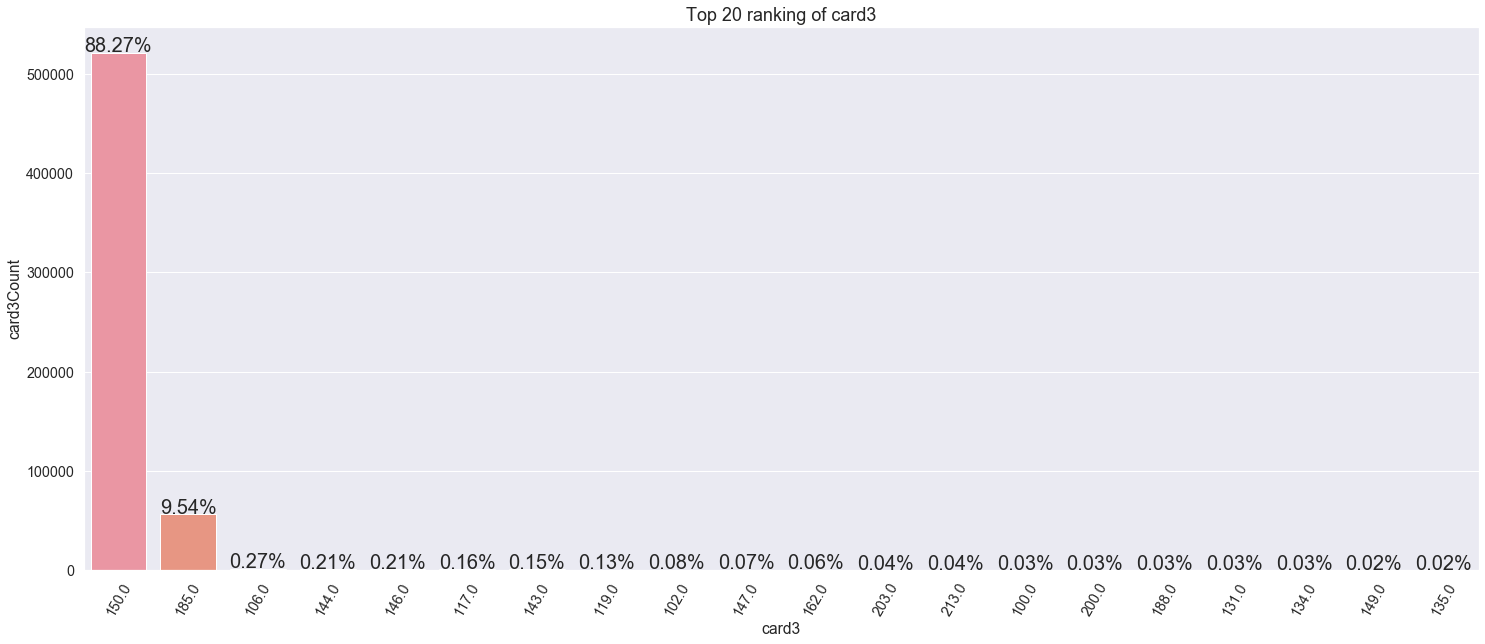

Total no. of card3 : 114
Missing Data for card3 : 0.27%
Top 20 :
 card3
150.0    150.0
185.0    185.0
106.0    106.0
144.0    144.0
146.0    146.0
117.0    117.0
143.0    143.0
119.0    119.0
102.0    102.0
147.0    147.0
162.0    162.0
203.0    203.0
213.0    213.0
100.0    100.0
200.0    200.0
188.0    188.0
131.0    131.0
134.0    134.0
149.0    149.0
135.0    135.0
Name: card3, dtype: float64


In [14]:
card3_Grp = pd.DataFrame()
card3_Grp['card3Count'] = train_merged.groupby(['card3'])['card3'].count()
card3_Grp['card3'] = card3_Grp.index

# There are too many Devices, so we will subset the top 20
card3_grp_top = card3_Grp.sort_values(by='card3Count',ascending=False).head(20)
order_card3 = card3_grp_top.sort_values(by='card3Count',ascending=False)['card3']

plt.figure(figsize=(25, 10))
sns.set(color_codes=True)
sns.set(font_scale = 1.3)
ax = sns.barplot(x='card3', y='card3Count', data=card3_grp_top, order=order_card3)
ax.set_title('Top 20 ranking of card3', fontsize=18)
for rectBox in ax.patches:
    count = rectBox.get_height()
    #print("Counts :", count)    
    ax.text(rectBox.get_x() + rectBox.get_width()/2.,
            count + 1000,
            '{:1.2f}%'.format(count/total_counts*100),
            ha="center", fontsize=20)


xt = plt.xticks(rotation=60)
plt.show()

print("Total no. of card3 :", len(card3_Grp.index))
print("Missing Data for card3 : " +
      '{:1.2f}%'.format(train_merged['card3'].isnull().sum() / total_counts * 100))
print("Top 20 :\n", card3_grp_top['card3'])

for ctr in range(len(card3_grp_top)):
    if (card3_grp_top.iloc[ctr]['card3'] == -999):
        print("Found in Index", str(ctr) + ":", card3_grp_top.iloc[ctr]['card3Count'])
        print("Missing Data : " + '{:1.2f}%'.format(card3_grp_top.iloc[ctr]['card3Count'] / total_counts * 100))

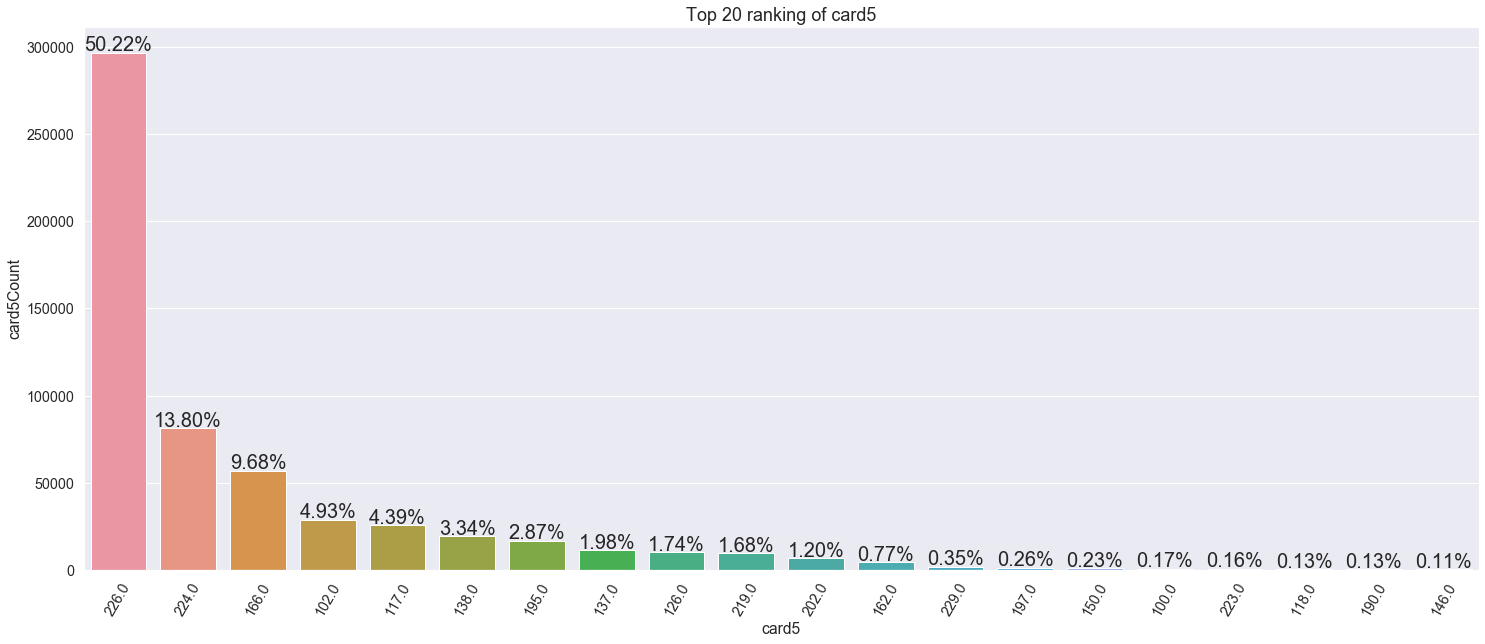

Total no. of card5 : 119
Missing Data for card5 : 0.72%
Top 20 :
 card5
226.0    226.0
224.0    224.0
166.0    166.0
102.0    102.0
117.0    117.0
138.0    138.0
195.0    195.0
137.0    137.0
126.0    126.0
219.0    219.0
202.0    202.0
162.0    162.0
229.0    229.0
197.0    197.0
150.0    150.0
100.0    100.0
223.0    223.0
118.0    118.0
190.0    190.0
146.0    146.0
Name: card5, dtype: float64


In [15]:
card5_Grp = pd.DataFrame()
card5_Grp['card5Count'] = train_merged.groupby(['card5'])['card5'].count()
card5_Grp['card5'] = card5_Grp.index

# There are too many Devices, so we will subset the top 20
card5_grp_top = card5_Grp.sort_values(by='card5Count',ascending=False).head(20)
order_card5 = card5_grp_top.sort_values(by='card5Count',ascending=False)['card5']

plt.figure(figsize=(25, 10))
sns.set(color_codes=True)
sns.set(font_scale = 1.3)
ax = sns.barplot(x='card5', y='card5Count', data=card5_grp_top, order=order_card5)
ax.set_title('Top 20 ranking of card5', fontsize=18)
for rectBox in ax.patches:
    count = rectBox.get_height()
    #print("Counts :", count)    
    ax.text(rectBox.get_x() + rectBox.get_width()/2.,
            count + 1000,
            '{:1.2f}%'.format(count/total_counts*100),
            ha="center", fontsize=20)

xt = plt.xticks(rotation=60)
plt.show()

print("Total no. of card5 :", len(card5_Grp.index))
print("Missing Data for card5 : " +
      '{:1.2f}%'.format(train_merged['card5'].isnull().sum() / total_counts * 100))
print("Top 20 :\n", card5_grp_top['card5'])

for ctr in range(len(card5_grp_top)):
    if (card5_grp_top.iloc[ctr]['card5'] == -999):
        print("Found in Index", str(ctr) + ":", card5_grp_top.iloc[ctr]['card5Count'])
        print("Missing Data : " + '{:1.2f}%'.format(card5_grp_top.iloc[ctr]['card5Count'] / total_counts * 100))

### <B>3. addr1 and addr2</B>

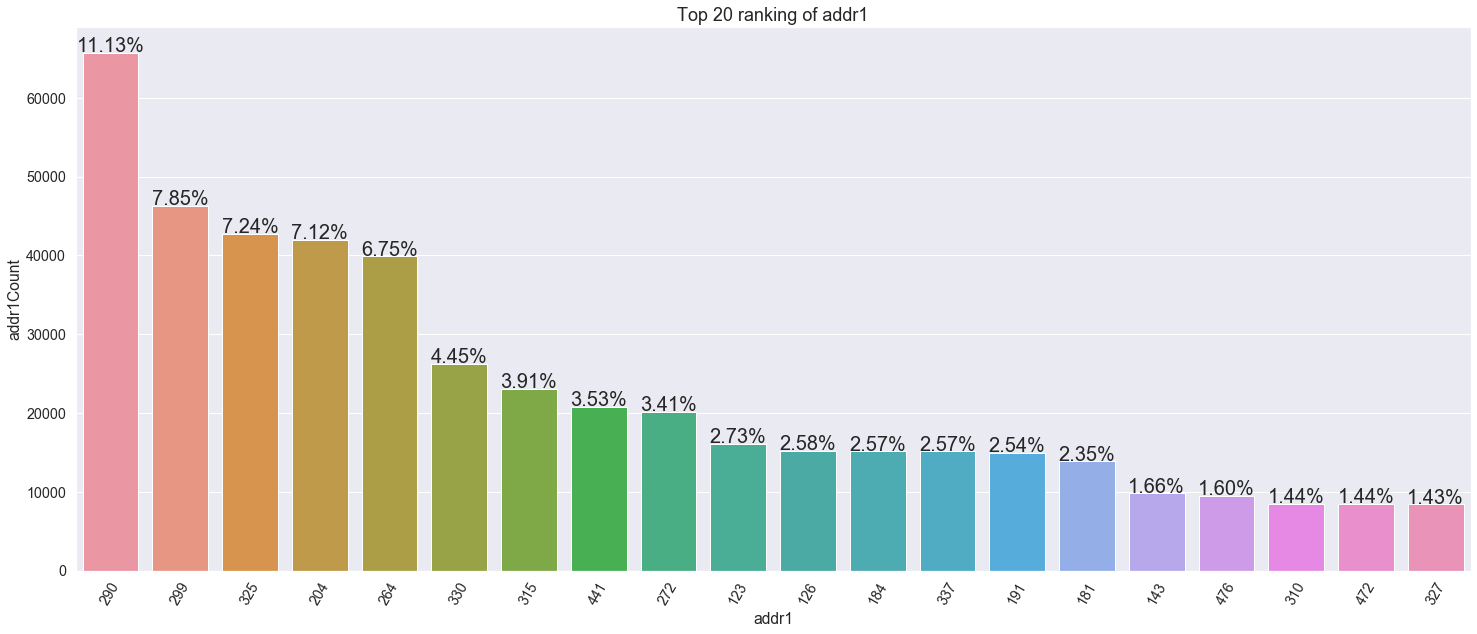

Total no. of addr1 : 332
Missing Data for addr1 : 0.00%
Top 20 :
 addr1
290    290
299    299
325    325
204    204
264    264
330    330
315    315
441    441
272    272
123    123
126    126
184    184
337    337
191    191
181    181
143    143
476    476
310    310
472    472
327    327
Name: addr1, dtype: int64


In [16]:
# First create a dataframe with 2 cols: addr2 and addr2 count
addr1_Grp = pd.DataFrame()
addr1_Grp['addr1Count'] = train_merged.groupby(['addr1'])['addr1'].count()
addr1_Grp['addr1'] = addr1_Grp.index

# There are too many Devices, so we will subset the top 20
addr1_grp_top = addr1_Grp.sort_values(by='addr1Count',ascending=False).head(20)
order_addr1 = addr1_grp_top.sort_values(by='addr1Count',ascending=False)['addr1']

plt.figure(figsize=(25, 10))
sns.set(color_codes=True)
sns.set(font_scale = 1.3)
ax = sns.barplot(x='addr1', y='addr1Count', data=addr1_grp_top, order=order_addr1)
ax.set_title('Top 20 ranking of addr1', fontsize=18)
for rectBox in ax.patches:
    count = rectBox.get_height()
    #print("Counts :", count)    
    ax.text(rectBox.get_x() + rectBox.get_width()/2.,
            count + 100,
            '{:1.2f}%'.format(count/total_counts*100),
            ha="center", fontsize=20)

xt = plt.xticks(rotation=60)
plt.show()

print("Total no. of addr1 :", len(addr1_Grp.index))
print("Missing Data for addr1 : " +
      '{:1.2f}%'.format(train_merged['addr1'].isnull().sum() / total_counts * 100))
print("Top 20 :\n", addr1_grp_top['addr1'])

for ctr in range(len(addr1_grp_top)):
    if (addr1_grp_top.iloc[ctr]['addr1'] == -999):
        print("Found in Index", str(ctr) + ":", addr1_grp_top.iloc[ctr]['addr1Count'])
        print("Missing Data : " + '{:1.2f}%'.format(addr1_grp_top.iloc[ctr]['addr1Count'] / total_counts * 100))

In [17]:
df = pd.DataFrame(train_merged['addr1'], index = train_merged.index)
# Getting the unqiue values
df = df.nunique() #.value_counts()
print (df)

addr1    332
dtype: int64


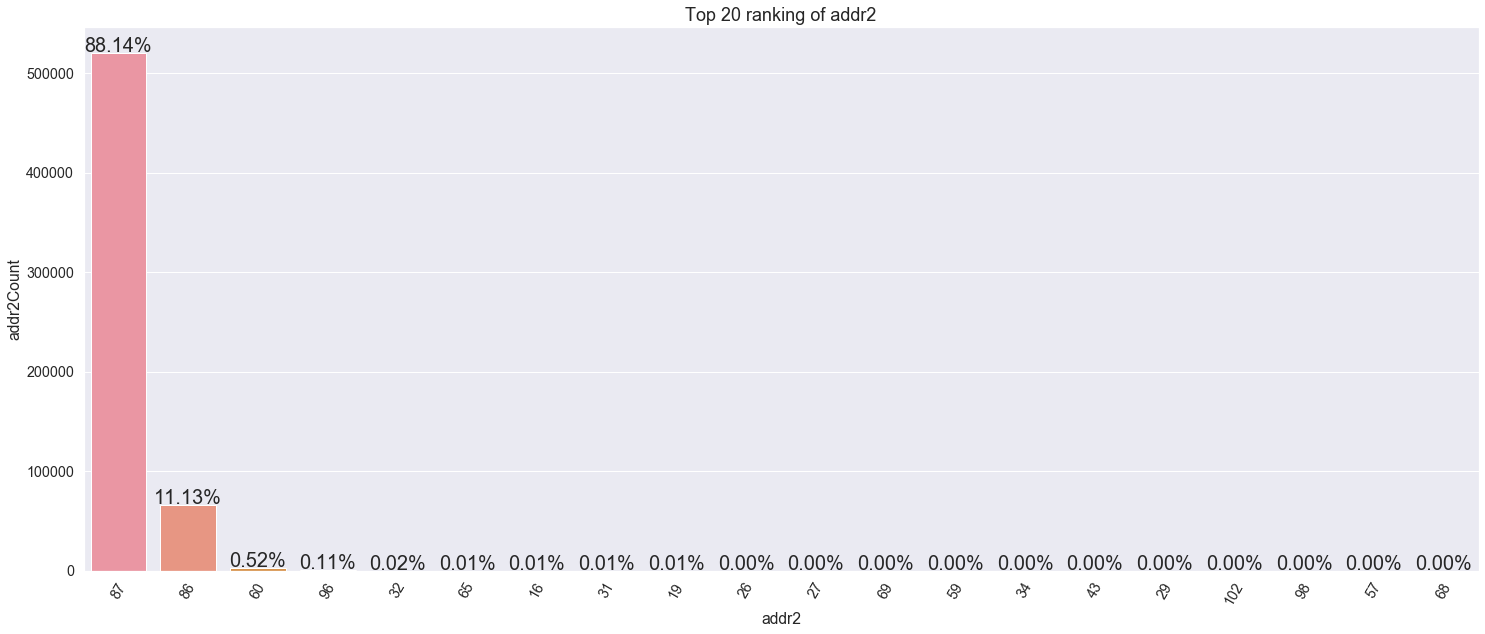

Total no. of addr2 : 74
Missing Data for addr2 : 0.00%
Top 20 :
 addr2
87      87
86      86
60      60
96      96
32      32
65      65
16      16
31      31
19      19
26      26
27      27
69      69
59      59
34      34
43      43
29      29
102    102
98      98
57      57
68      68
Name: addr2, dtype: int64


In [18]:
# First create a dataframe with 2 cols: addr2 and addr2 count
addr2_Grp = pd.DataFrame()
addr2_Grp['addr2Count'] = train_merged.groupby(['addr2'])['addr2'].count()
addr2_Grp['addr2'] = addr2_Grp.index

# There are too many Devices, so we will subset the top 20
addr2_grp_top = addr2_Grp.sort_values(by='addr2Count',ascending=False).head(20)
order_addr2 = addr2_grp_top.sort_values(by='addr2Count',ascending=False)['addr2']

plt.figure(figsize=(25, 10))
sns.set(color_codes=True)
sns.set(font_scale = 1.3)
ax = sns.barplot(x='addr2', y='addr2Count', data=addr2_grp_top, order=order_addr2)
ax.set_title('Top 20 ranking of addr2', fontsize=18)
for rectBox in ax.patches:
    count = rectBox.get_height()
    #print("Counts :", count)    
    ax.text(rectBox.get_x() + rectBox.get_width()/2.,
            count + 1000,
            '{:1.2f}%'.format(count/total_counts*100),
            ha="center", fontsize=20)


xt = plt.xticks(rotation=60)
plt.show()

print("Total no. of addr2 :", len(addr2_Grp.index))
print("Missing Data for addr2 : " +
      '{:1.2f}%'.format(train_merged['addr2'].isnull().sum() / total_counts * 100))
print("Top 20 :\n", addr2_grp_top['addr2'])


for ctr in range(len(addr2_grp_top)):
    if (addr2_grp_top.iloc[ctr]['addr2'] == -999):
        print("Found in Index", str(ctr) + ":", addr2_grp_top.iloc[ctr]['addr2Count'])
        print("Missing Data : " + '{:1.2f}%'.format(addr2_grp_top.iloc[ctr]['addr2Count'] / total_counts * 100))

In [19]:
df = pd.DataFrame(train_merged['addr2'], index = train_merged.index)
# Getting the unqiue values
df = df.nunique() #.value_counts()
print (df)

addr2    74
dtype: int64


### <B>4. P_emaildomain</B>

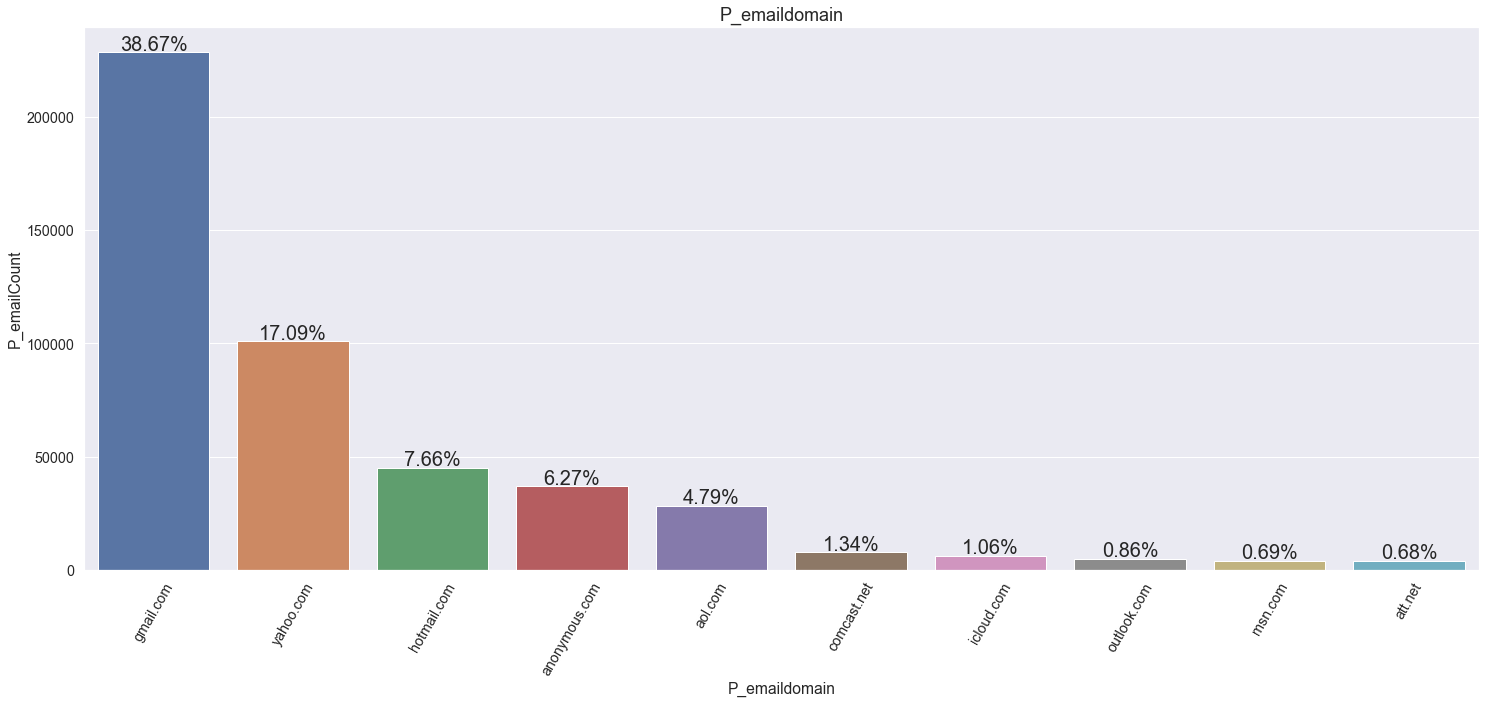

Total no. of P_emaildomain : 59
Missing Data for P_emaildomain : 15.99%


In [20]:
# First create a dataframe with 2 cols: P_emaildomain and Email count
P_EmailGrp = pd.DataFrame()
P_EmailGrp['P_emailCount'] = train_merged.groupby(['P_emaildomain'])['P_emaildomain'].count()
P_EmailGrp['P_emaildomain'] = P_EmailGrp.index

# There are too many P_emaildomain, we will just take the top 10
group_top = P_EmailGrp.sort_values(by='P_emailCount',ascending=False).head(10)

plt.figure(figsize=(25, 10))
sns.set(color_codes=True)
sns.set(font_scale = 1.3)
ax = sns.barplot(x="P_emaildomain", y="P_emailCount", data=group_top)
ax.set_title('P_emaildomain', fontsize=18)
for rectBox in ax.patches:
    count = rectBox.get_height()
    #print("Counts :", count)    
    ax.text(rectBox.get_x() + rectBox.get_width()/2.,
            count + 1000,
            '{:1.2f}%'.format(count/total_counts*100),
            ha="center", fontsize=20)


xt = plt.xticks(rotation=60)
plt.show()

print("Total no. of P_emaildomain :", len(P_EmailGrp.index))
print("Missing Data for P_emaildomain : " +
      '{:1.2f}%'.format(train_merged['P_emaildomain'].isnull().sum() / total_counts * 100))

for ctr in range(len(group_top)):
    if (group_top.iloc[ctr]['P_emaildomain'] == -999):
        print("Found in Index", str(ctr) + ":", group_top.iloc[ctr]['P_emailCount'])
        print("Missing Data : " + '{:1.2f}%'.format(group_top.iloc[ctr]['P_emailCount'] / total_counts * 100))

### <B>5. R_emaildomain</B>

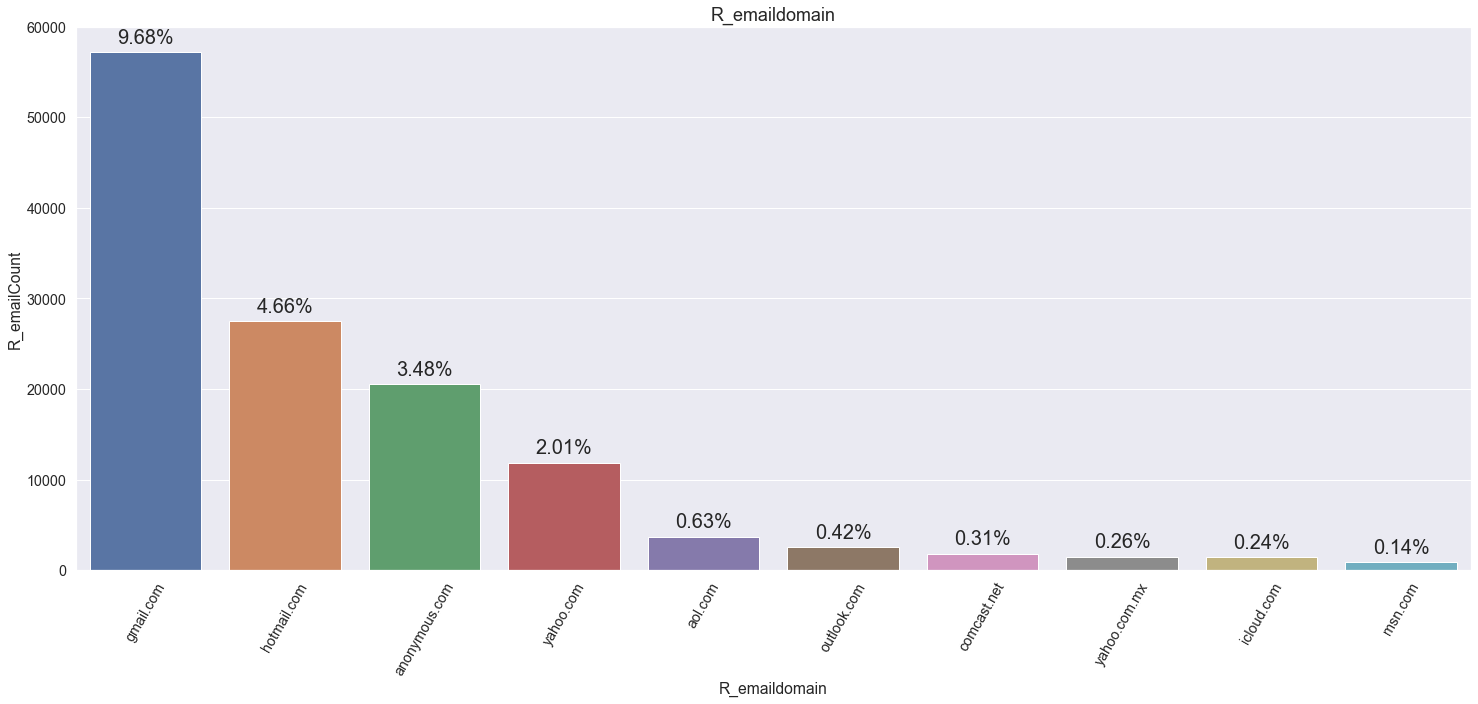

Total no. of R_emaildomain : 60
Missing Data for R_emaildomain : 76.75%


In [21]:
# First create a dataframe with 2 cols: R_emaildomain and Email count
R_EmailGrp = pd.DataFrame()
R_EmailGrp['R_emailCount'] = train_merged.groupby(['R_emaildomain'])['R_emaildomain'].count()
R_EmailGrp['R_emaildomain'] = R_EmailGrp.index

# There are too many Devices, so we will subset the top 10
group_top = R_EmailGrp.sort_values(by='R_emailCount',ascending=False).head(10)

plt.figure(figsize=(25, 10))
sns.set(color_codes=True)
sns.set(font_scale = 1.3)
ax = sns.barplot(x="R_emaildomain", y="R_emailCount", data=group_top)
ax.set_title('R_emaildomain', fontsize=18)
for rectBox in ax.patches:
    count = rectBox.get_height()
    #print("Counts :", count)    
    ax.text(rectBox.get_x() + rectBox.get_width()/2.,
            count + 1000,
            '{:1.2f}%'.format(count/total_counts*100),
            ha="center", fontsize=20)


xt = plt.xticks(rotation=60)
plt.show()

print("Total no. of R_emaildomain :", len(R_EmailGrp.index))
print("Missing Data for R_emaildomain : " +
      '{:1.2f}%'.format(train_merged['R_emaildomain'].isnull().sum() / total_counts * 100))

for ctr in range(len(group_top)):
    if (group_top.iloc[ctr]['R_emaildomain'] == -999):
        print("Found in Index", str(ctr) + ":", group_top.iloc[ctr]['R_emailCount'])
        print("Missing Data : " + '{:1.2f}%'.format(group_top.iloc[ctr]['R_emailCount'] / total_counts * 100))

### <B>6. M1 - M9</B>

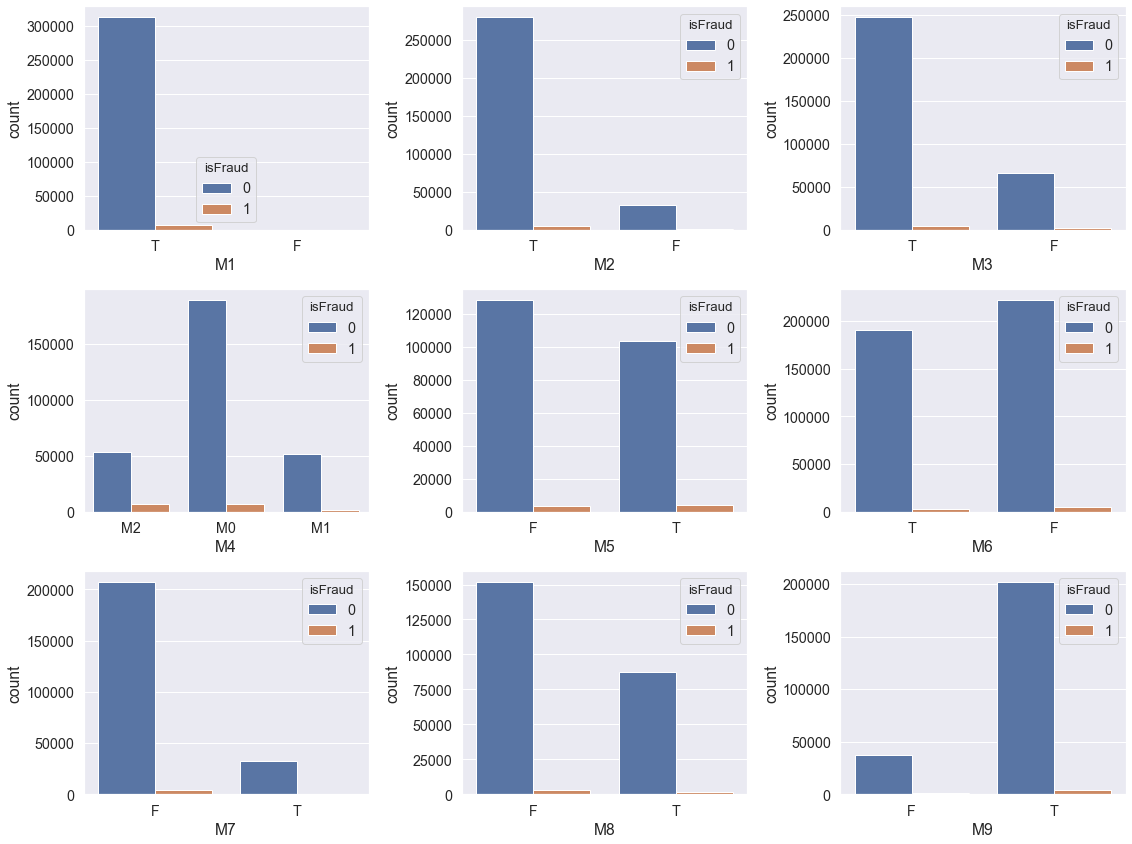

In [22]:
M1_loc = train_merged.columns.get_loc("M1")
M9_loc = train_merged.columns.get_loc("M9")
df_m = train_merged.iloc[:,M1_loc:M9_loc+1] #subset dataframe M1-M9
df_m['isFraud'] = train_merged.isFraud 

df_m_cols = df_m.columns
figure, axes = plt.subplots(3, 3, figsize=(16, 12))
count = 0
for i in range(3): # rows loop
    for j in range(3): # cols loop
        mplot = sns.countplot(x=df_m_cols[count], hue = 'isFraud', data=df_m, ax=axes[i,j])
        count += 1 # to loop over col-names
plt.tight_layout()

In [23]:
print(df_m_cols.values)

['M1' 'M2' 'M3' 'M4' 'M5' 'M6' 'M7' 'M8' 'M9' 'isFraud']


In [24]:
for ctr in range(len(df_m_cols.values)): # df_m_cols loop
    col_name = df_m_cols[ctr]
    df_m1_unique = df_m[col_name].nunique()
    df_m1_unique_counts = df_m[col_name].value_counts()
    print ("No. of unique values in", col_name, " :", df_m1_unique)
    print ("No. of counts per unique value in ", col_name, " :\n", df_m1_unique_counts)
    print("Missing Data for", col_name + " : " +
          '{:1.2f}%'.format(train_merged[col_name].isnull().sum() / total_counts * 100))
    print("----------------------------------------")

No. of unique values in M1  : 2
No. of counts per unique value in  M1  :
 T    319415
F        25
Name: M1, dtype: int64
Missing Data for M1 : 45.91%
----------------------------------------
No. of unique values in M2  : 2
No. of counts per unique value in  M2  :
 T    285468
F     33972
Name: M2, dtype: int64
Missing Data for M2 : 45.91%
----------------------------------------
No. of unique values in M3  : 2
No. of counts per unique value in  M3  :
 T    251731
F     67709
Name: M3, dtype: int64
Missing Data for M3 : 45.91%
----------------------------------------
No. of unique values in M4  : 3
No. of counts per unique value in  M4  :
 M0    196405
M2     59865
M1     52826
Name: M4, dtype: int64
Missing Data for M4 : 47.66%
----------------------------------------
No. of unique values in M5  : 2
No. of counts per unique value in  M5  :
 F    132491
T    107567
Name: M5, dtype: int64
Missing Data for M5 : 59.35%
----------------------------------------
No. of unique values in M6  : 

### <B>7. DeviceType</B>

Counts : 449730
Counts : 55645
Counts : 85165


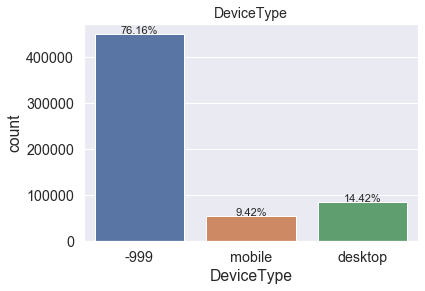

Missing Data : 76.16%


In [25]:
df_dType = pd.DataFrame({'DeviceType' : train_merged['DeviceType']})
df_dType['DeviceType'] = df_dType['DeviceType'].fillna(-999)

ax = sns.countplot(x='DeviceType', data=df_dType)
ax.set_title('DeviceType', fontsize=14)
for rectBox in ax.patches:
    count = rectBox.get_height()
    print("Counts :", count)
    
    ax.text(rectBox.get_x() + rectBox.get_width()/2.,
            count + 1000,
            '{:1.2f}%'.format(count/total_counts*100),
            ha="center", fontsize=11)

# Change the x-labels
#plt.xticks(np.arange(3), ("Missing", "Yes", "No"))
plt.show()

print("Missing Data : " + '{:1.2f}%'.format(train_merged['DeviceType'].isnull().sum() / total_counts * 100))

### <B>8. DeviceInfo</B>

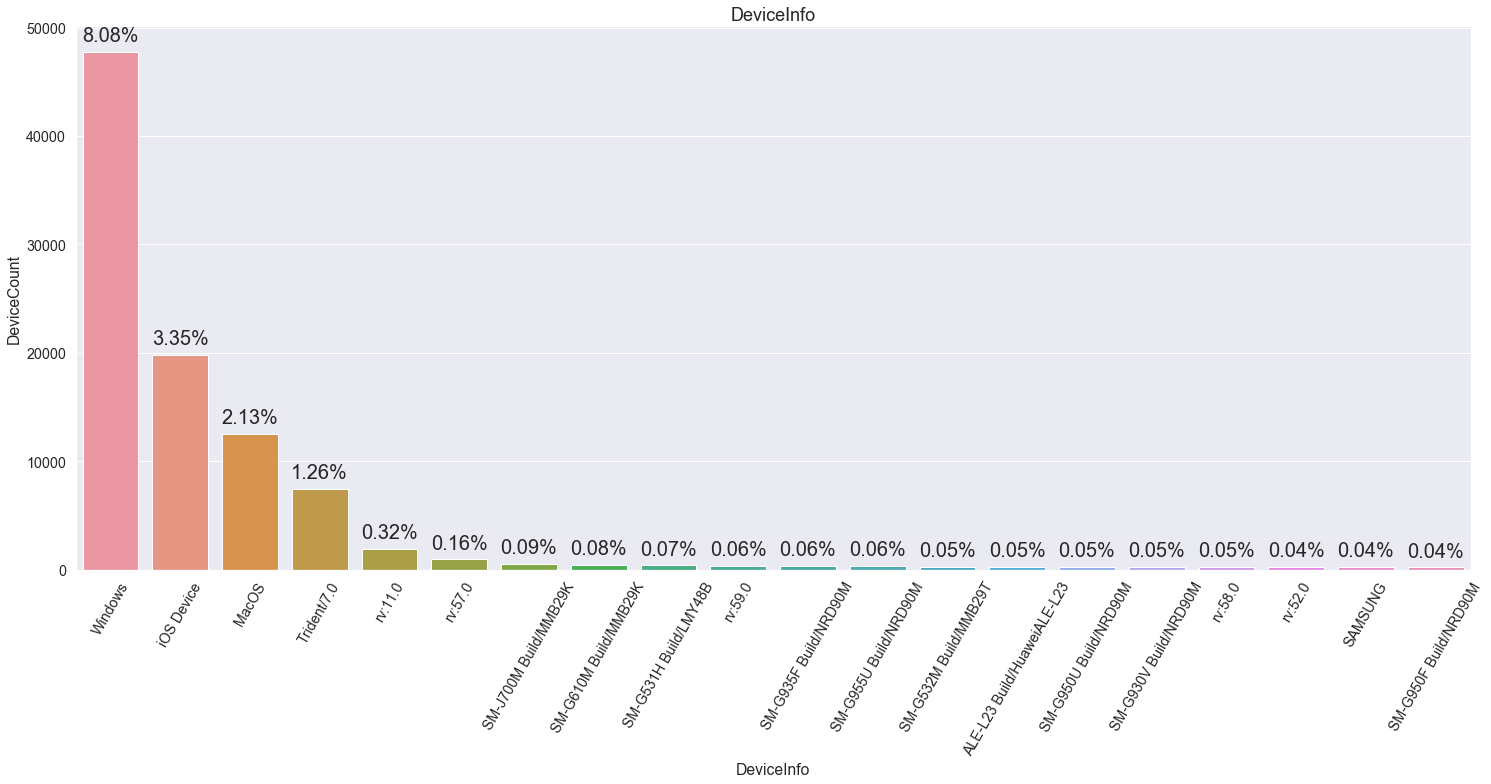

Total no. of DeviceInfo : 1786
Missing Data for DeviceInfo : 79.91%


In [26]:
# First create a dataframe with 2 cols: device info and the count by device
D_InfoGrp = pd.DataFrame()
D_InfoGrp['DeviceCount'] = train_merged.groupby(['DeviceInfo'])['DeviceInfo'].count()
D_InfoGrp['DeviceInfo'] = D_InfoGrp.index

# There are too many Devices, so we will subset the top 20
group_top = D_InfoGrp.sort_values(by='DeviceCount',ascending=False).head(20)

plt.figure(figsize=(25, 10))
sns.set(color_codes=True)
sns.set(font_scale = 1.3)
ax = sns.barplot(x="DeviceInfo", y="DeviceCount", data=group_top)
ax.set_title('DeviceInfo', fontsize=18)

for rectBox in ax.patches:
    count = rectBox.get_height()
    #print("Counts :", count)    
    ax.text(rectBox.get_x() + rectBox.get_width()/2.,
            count + 1000,
            '{:1.2f}%'.format(count/total_counts*100),
            ha="center", fontsize=20)


xt = plt.xticks(rotation=60)
plt.show()

print("Total no. of DeviceInfo :", len(D_InfoGrp.index))
print("Missing Data for DeviceInfo : " +
      '{:1.2f}%'.format(train_merged['DeviceInfo'].isnull().sum() / total_counts * 100))

for ctr in range(len(group_top)):
    if (group_top.iloc[ctr]['DeviceInfo'] == -999):
        print("Found in Index", str(ctr) + ":", group_top.iloc[ctr]['DeviceCount'])
        print("Missing Data : " + '{:1.2f}%'.format(group_top.iloc[ctr]['DeviceCount'] / total_counts * 100))

### <B>9. Id_01 - 38</B>

In [27]:
# Initialized variables
total_counts = len(train_merged)

i_cols = [c for c in train_merged if c[0] == 'i']

# Example : train_merged['id_01'].value_counts()
for ctr in range(len(i_cols)):
    col_name = i_cols[ctr]
    df_unique = train_merged[col_name].nunique()
    df_unique_counts = train_merged[col_name].value_counts()
    print ("No. of unique values in", col_name, " :", df_unique)
    #print ("No. of counts per unique value in", col_name, " :\n", df_unique_counts)
    print("Missing Data : " + '{:1.2f}%'.format(train_merged[col_name].isnull().sum() / total_counts * 100))
    
train_merged[i_cols].head()

No. of unique values in isFraud  : 2
Missing Data : 0.00%
No. of unique values in id_01  : 77
Missing Data : 75.58%
No. of unique values in id_02  : 115655
Missing Data : 76.15%
No. of unique values in id_03  : 24
Missing Data : 88.77%
No. of unique values in id_04  : 15
Missing Data : 88.77%
No. of unique values in id_05  : 93
Missing Data : 76.82%
No. of unique values in id_06  : 101
Missing Data : 76.82%
No. of unique values in id_07  : 84
Missing Data : 99.13%
No. of unique values in id_08  : 94
Missing Data : 99.13%
No. of unique values in id_09  : 46
Missing Data : 87.31%
No. of unique values in id_10  : 62
Missing Data : 87.31%
No. of unique values in id_11  : 365
Missing Data : 76.13%
No. of unique values in id_12  : 2
Missing Data : 75.58%
No. of unique values in id_13  : 54
Missing Data : 78.44%
No. of unique values in id_14  : 25
Missing Data : 86.45%
No. of unique values in id_15  : 3
Missing Data : 76.13%
No. of unique values in id_16  : 2
Missing Data : 78.10%
No. of uniq

,isFraud,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T


In [28]:
missing_data_pc = ((train_merged.isnull().sum() / total_counts) * 100).round(2).astype(str) + "%"
missing_data_pc.index

Index(['isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1',
       'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=433)

In [29]:
# Print all values in data
sorted_missing_data_pc = missing_data_pc.sort_values(ascending=False)

print("Missing values in data :\n" + sorted_missing_data_pc.to_string())
print("\nTotal number of columns :", len(sorted_missing_data_pc))

Missing values in data :
id_24              99.2%
id_26             99.13%
id_21             99.13%
id_25             99.13%
id_07             99.13%
id_08             99.13%
id_27             99.12%
id_22             99.12%
id_23             99.12%
dist2             93.63%
id_18             92.36%
id_04             88.77%
id_03             88.77%
id_33             87.59%
id_09             87.31%
id_10             87.31%
id_30             86.87%
id_32             86.86%
id_34             86.82%
id_14             86.45%
V154              86.12%
V152              86.12%
V153              86.12%
V156              86.12%
V155              86.12%
V159              86.12%
V157              86.12%
V166              86.12%
V164              86.12%
V162              86.12%
V160              86.12%
V158              86.12%
V161              86.12%
V163              86.12%
V151              86.12%
V150              86.12%
V138              86.12%
V139              86.12%
V140              86.12%


In [30]:
total_num_features = len(sorted_missing_data_pc)
selected_num_features = 0
selected_features_above_threshold = []
for ctr in range(total_num_features): # cols loop
    float_val = float(sorted_missing_data_pc[ctr].rstrip('%'))
    if float_val > 77.00 :
        selected_num_features += 1
        selected_features_above_threshold.append(sorted_missing_data_pc.index[ctr])
        #print("'" + sorted_missing_data_pc.index[ctr] + "',") #, " :", correlation_fraud[ctr])

# Get the balance features after dropping columns above threshold
selected_balance_features = train_merged.columns.difference(selected_features_above_threshold)

print("Total no. of features :", len(train_merged.columns))
print("Total no. of selected features above threshold :", selected_num_features)
print("Selected features above missing thresholds and to be dropped :\n",selected_features_above_threshold)

print("\nTotal no. of balance features :", len(selected_balance_features))
print("Balance features after dropping features :\n",selected_balance_features)

Total no. of features : 433
Total no. of selected features above threshold : 116
Selected features above missing thresholds and to be dropped :
 ['id_24', 'id_26', 'id_21', 'id_25', 'id_07', 'id_08', 'id_27', 'id_22', 'id_23', 'dist2', 'id_18', 'id_04', 'id_03', 'id_33', 'id_09', 'id_10', 'id_30', 'id_32', 'id_34', 'id_14', 'V154', 'V152', 'V153', 'V156', 'V155', 'V159', 'V157', 'V166', 'V164', 'V162', 'V160', 'V158', 'V161', 'V163', 'V151', 'V150', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V165', 'V149', 'V148', 'V147', 'V146', 'V334', 'V333', 'V339', 'V338', 'V337', 'V336', 'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V335', 'V330', 'V331', 'V332', 'V329', 'DeviceInfo', 'id_13', 'id_16', 'V276', 'V260', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V269', 'V233', 'V232', 'V231', 'V273', 'V274', 'V261', 'V257', 'V258', 'V240', 'V235', 'V236', 'V254', 'V253', 'V252', 'V237', 'V249', 'V248', 'V247', 'V246', 'V244', 'V243', 'V242', 'V275', 'V

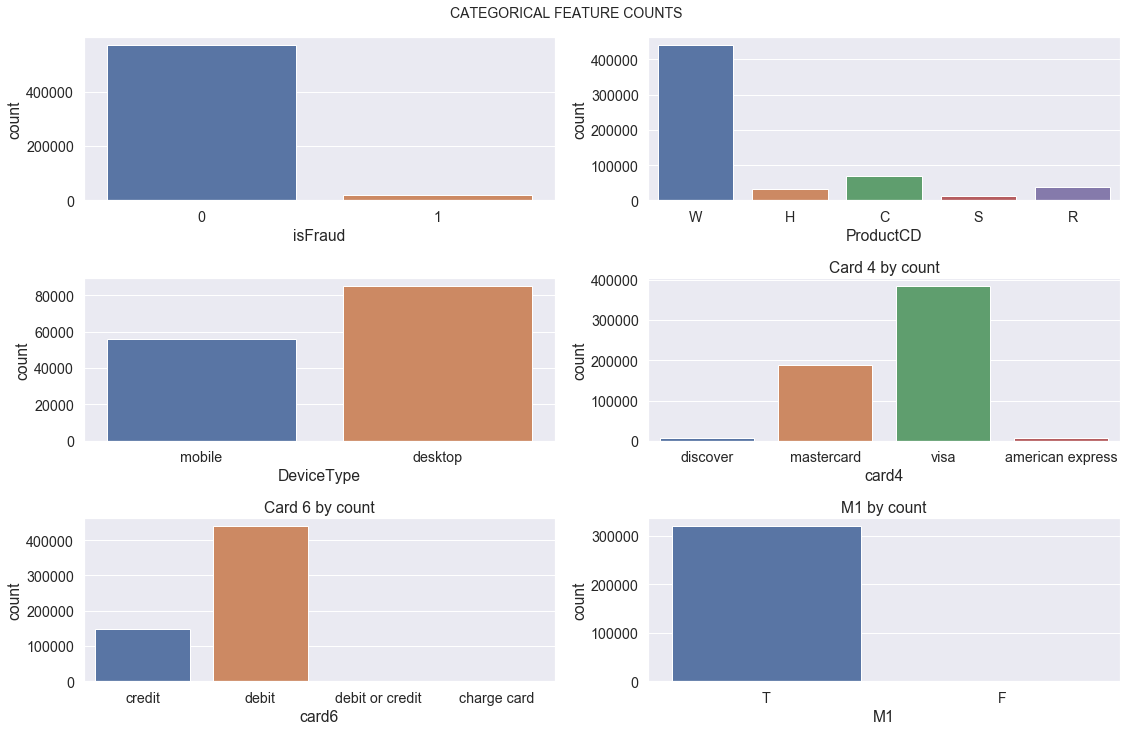

In [28]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 10))
fig.subplots_adjust(hspace=1.0)
fig.suptitle('Categorical Feature counts'.upper(), y=1.02, fontsize=14)

isFraud = sns.countplot(x=train_merged['isFraud'], data=train_merged, ax=axes[0][0])
ProductCD = sns.countplot(x=train_merged['ProductCD'], data=train_merged, ax=axes[0][1])
DeviceType = sns.countplot(x=train_merged['DeviceType'], data=train_merged, ax=axes[1][0])
card4 = sns.countplot(x=train_merged['card4'], data=train_merged, ax=axes[1][1]).set_title("Card 4 by count")
card6 = sns.countplot(x=train_merged['card6'], data=train_merged, ax=axes[2][0]).set_title("Card 6 by count")
m1 = sns.countplot(x=train_merged['M1'], data=train_merged, ax=axes[2][1]).set_title("M1 by count")

plt.tight_layout()

# Inspecting Parameters is Fraud instances

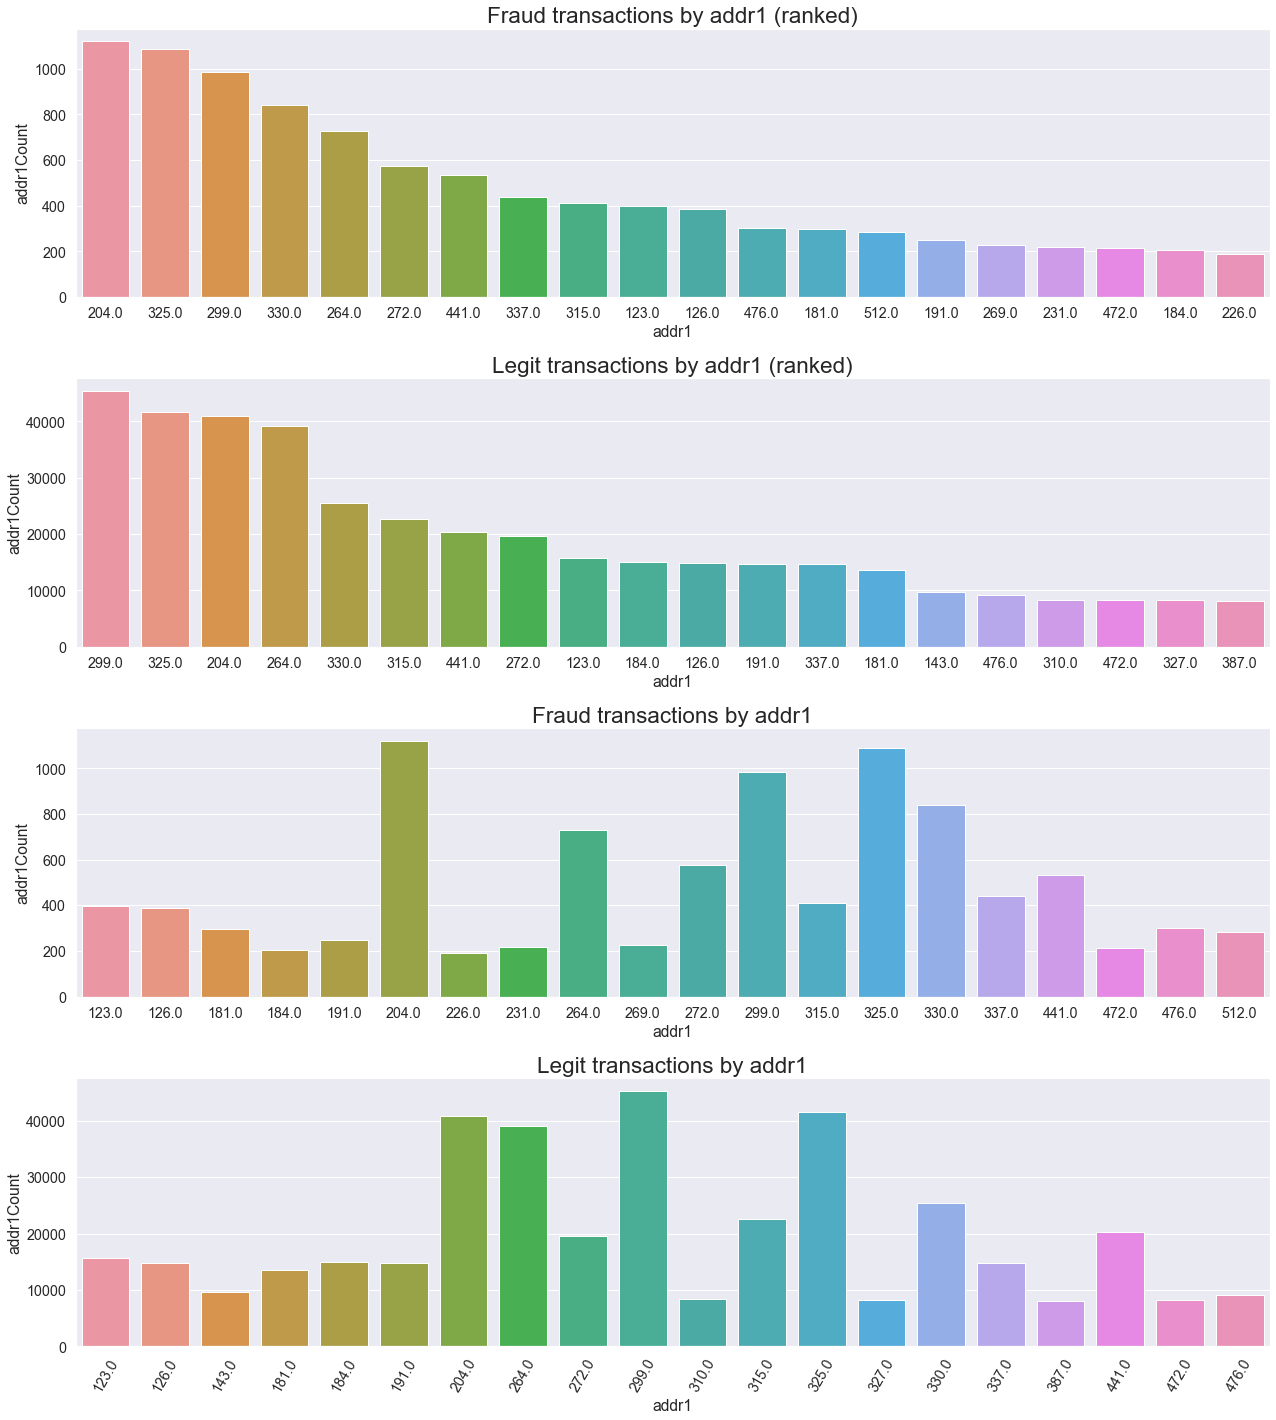

In [29]:
# Subset fraud dataset
addr = 'addr1'
addrC = 'addr1Count'
fraud = pd.DataFrame()
is_fraud = train_merged[train_merged['isFraud']==1]

fraud[addrC] = is_fraud.groupby([addr])[addr].count()
fraud[addr] = fraud.index

# Subset NOT fraud dataset
NOfraud = pd.DataFrame()
no_fraud = train_merged[train_merged['isFraud']==0]
NOfraud[addrC] = no_fraud.groupby([addr])[addr].count()
NOfraud[addr] = NOfraud.index

# There are too many addr, so we will subset the top 20
group_top_f = fraud.sort_values(by=addrC,ascending=False).head(20)
order_f = group_top_f.sort_values(by=addrC,ascending=False)[addr]

group_top_l = NOfraud.sort_values(by=addrC,ascending=False).head(20)
order_l = group_top_l.sort_values(by=addrC,ascending=False)[addr]

f, axes = plt.subplots(4, 1, figsize=(18, 20))

sns.set(color_codes=True)
sns.set(font_scale = 1.3)
ax = sns.barplot(x=addr, y=addrC, data=group_top_f, order = order_f, ax=axes[0])
bx = sns.barplot(x=addr, y=addrC, data=group_top_l, order = order_l, ax=axes[1])

az = sns.barplot(x=addr, y=addrC, data=group_top_f, ax=axes[2])
bz = sns.barplot(x=addr, y=addrC, data=group_top_l, ax=axes[3])

font_size= {'size': 'x-large'}
ax.set_title("Fraud transactions by addr1 (ranked)", **font_size)
bx.set_title("Legit transactions by addr1 (ranked)", **font_size)

az.set_title("Fraud transactions by addr1", **font_size)
bz.set_title("Legit transactions by addr1", **font_size)

xt = plt.xticks(rotation=60)
plt.tight_layout()

In [30]:
print("No. of Frauds :", is_fraud.shape)
print("No. of Non-Frauds :", no_fraud.shape)

No. of Frauds : (20663, 433)
No. of Non-Frauds : (569877, 433)


In [31]:
is_fraud.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,1,89760,445.000,W,18268,583.0,150.0,visa,226.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987240,1,90193,37.098,C,13413,103.0,185.0,visa,137.0,credit,...,chrome 54.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M
2987243,1,90246,37.098,C,13413,103.0,185.0,visa,137.0,credit,...,chrome 54.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M
2987245,1,90295,37.098,C,13413,103.0,185.0,visa,137.0,credit,...,chrome 54.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M
2987288,1,90986,155.521,C,16578,545.0,185.0,visa,226.0,credit,...,chrome 62.0 for ios,NaN,NaN,NaN,F,F,F,F,mobile,NaN


In [32]:
features = train_merged.columns

print("Train Features : ", features)

Train Features :  Index(['isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1',
       'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=433)


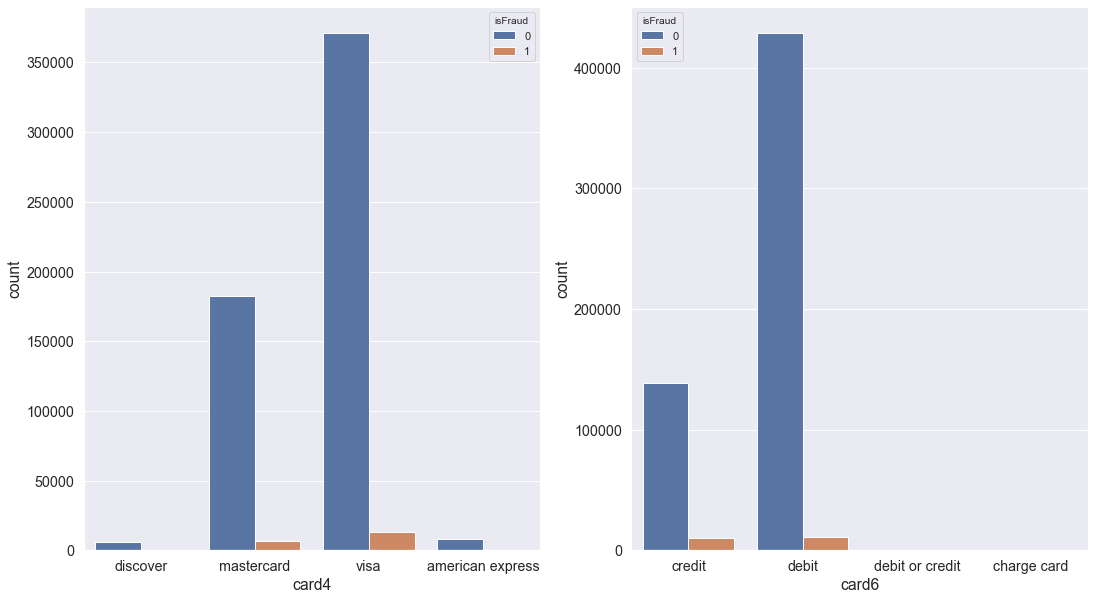

In [33]:
f, axes = plt.subplots(1, 2, figsize=(18, 10))
sns.set(color_codes=True)
card4 = sns.countplot(x='card4', hue="isFraud", data=train_merged, ax=axes[0])
card6 = sns.countplot(x='card6', hue="isFraud", data=train_merged, ax=axes[1])

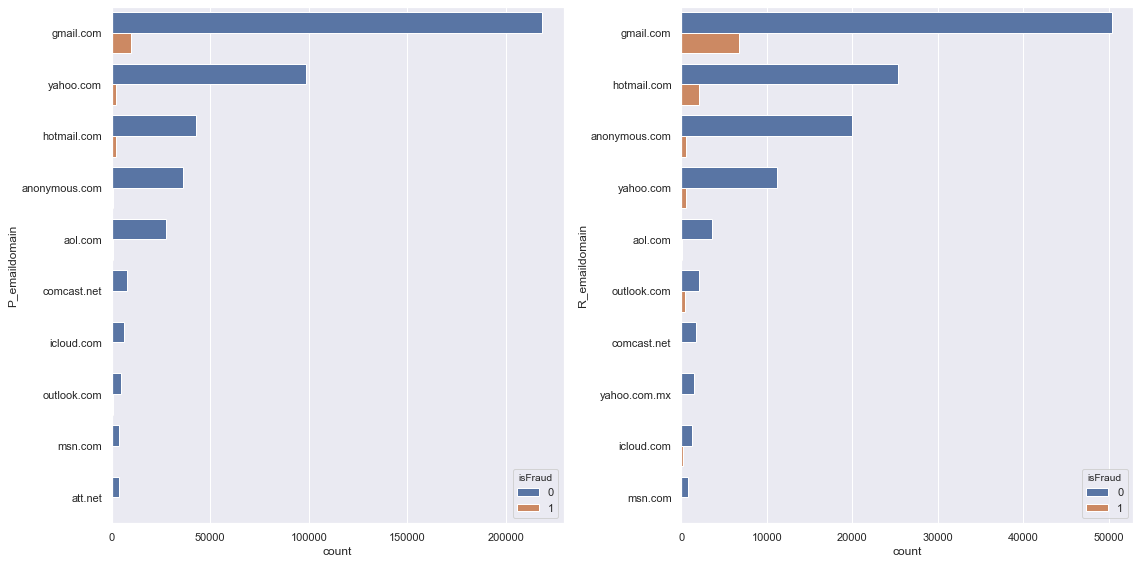

In [34]:
# Get top 10 
order_p=train_merged.P_emaildomain.value_counts().iloc[:10].index
order_r=train_merged.R_emaildomain.value_counts().iloc[:10].index

f, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.set(color_codes=True)
p_email = sns.countplot(y='P_emaildomain',  hue="isFraud", data=train_merged, order = order_p, ax=axes[0])
r_email = sns.countplot(y='R_emaildomain',  hue="isFraud", data=train_merged, order = order_r, ax=axes[1])
plt.tight_layout()

In [35]:
# Getting columns that starts with 'C'
c_cols = [c for c in train_merged if c[0] == 'C']
train_merged[c_cols].head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
TransactionID,,,,,,,,,,,,,,
2987000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
2987001,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2987002,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
2987003,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
2987004,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


In [36]:
df = pd.DataFrame(train_merged[c_cols], index = train_merged.index)

#df.C1.unique()
#output = df.drop_duplicates()
#output.groupby('C1').size()

# Getting the unqiue values
df = df.nunique() #.value_counts()

print (df)

C1     1657
C2     1216
C3       27
C4     1260
C5      319
C6     1328
C7     1103
C8     1253
C9      205
C10    1231
C11    1476
C12    1199
C13    1597
C14    1108
dtype: int64


In [37]:
d_cols = [c for c in train_merged if c[0] == 'D']
train_merged[d_cols].head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,
2987000,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,NaN,NaN
2987001,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2987002,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,NaN,NaN
2987003,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN
2987004,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mobile,SAMSUNG SM-G892A Build/NRD90M


In [38]:
m_cols = [c for c in train_merged if c[0] == 'M']
train_merged[m_cols].head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
TransactionID,,,,,,,,,
2987000,T,T,T,M2,F,T,NaN,NaN,NaN
2987001,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2987002,T,T,T,M0,F,F,F,F,F
2987003,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
2987004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
v_cols = [c for c in train_merged if c[0] == 'V']
train_merged[v_cols].head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
T_cols = [c for c in train_merged if c[0] == 'T']
train_merged[T_cols].head()

,TransactionDT,TransactionAmt
TransactionID,,
2987000,86400,68.5
2987001,86401,29.0
2987002,86469,59.0
2987003,86499,50.0
2987004,86506,50.0


In [45]:
# Obtained from missing_data_pc list
#[id_24...id_22]: 99.20%
# dist2         : 93.63%
# D7            : 93.41%
# id_18         : 92.36%
# D13           : 89.51%
# D14           : 89.47%
# D12           : 89.04%

#[id_04, id_03] : 88.77%
# [D6...id_09]  : 87.31%

#[id_30...id_14]: 86.87%
# [V151...V148] : 86.12%
# [V338...V337] : 86.05%

# [id_13,id_16] : 78.44%
# [V254, V269]  : 77.91%
# [id_05, id_06]: 76.82%
# R_emaildomain : 76.75%
#[id_20...id_17]: 76.42%

# [V167...V216] : 76.36%
# [V174...V189] : 76.32%
# [id_31, id_02]: 76.25%
#[id_29...id_38]: 76.13%
# [V221... V250]: 76.05%

# [id_01,id_12] : 75.58%
# dist1         : 59.65%
# M5            : 59.35%
# [M7 - M9]     : 58.64%
# D5            : 52.47%
# M4            : 47.66%
# D2            : 47.55%
# [V9 ... V4]   : 47.29%

# [M1 - M3]     : 45.91%
# D3            : 44.51%
# M6            : 28.68%
# [V43 ... V52] : 28.61%
# D4            : 28.6%
# P_emaildomain : 15.99%
# [V84 ... V85] : 15.10%
# D15           : 15.09%
# [V70 ... V53] : 13.06%
# [V34 ... V19] : 12.88%
# D10           : 12.87%
# addr1, addr2  : 11.13%


# Examine different Machine Learning models 

# Preprocessing

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

std_scaler = Pipeline([
    ("standard_scaler", StandardScaler())
])

In [23]:
# Delete data to free up memory 
del train_merged, test_merged, train_transaction, train_identity
del test_transaction, test_identity

# Garbage Collection
gc.collect

<function gc.collect>

# Fill NaNs

In [33]:
train_merged.shape

(590540, 433)

In [35]:
len(selected_features_above_threshold)

116

In [36]:
train_merged.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [37]:
# Assign values to NaN in the column
train_merged['R_emaildomain'] = train_merged['R_emaildomain'].fillna('gmail.com')
train_merged['M1'] = train_merged['M1'].fillna('T')
train_merged['M2'] = train_merged['M2'].fillna('T')
train_merged['M3'] = train_merged['M3'].fillna('T')
train_merged['M4'] = train_merged['M4'].fillna('M0')
train_merged['M5'] = train_merged['M5'].fillna('F')
train_merged['M6'] = train_merged['M6'].fillna('F')
train_merged['M7'] = train_merged['M7'].fillna('F')
train_merged['M8'] = train_merged['M8'].fillna('F')
train_merged['M9'] = train_merged['M9'].fillna('T')
train_merged['DeviceType'] = train_merged['DeviceType'].fillna('desktop') # Data Missing : 76.16%
train_merged['DeviceInfo'] = train_merged['DeviceInfo'].fillna('Windows') # Data Missing : 79.91%

# Approach 
1. drop the following 51 columns gives better scoring
2. fill the missing information

In [ ]:
drop_col = ['TransactionDT',
            'V300', 'V309', 'V111', 'C3', 'V124', 'V106', 'V125', 'V315', 'V134', 'V102',
            'V123', 'V316', 'V113', 'V136', 'V305', 'V110', 'V299', 'V289', 'V286', 'V318',
            'V103', 'V304', 'V116', 'V298', 'V284', 'V293', 'V137', 'V295', 'V301', 'V104',
            'V311', 'V115', 'V109', 'V119', 'V321', 'V114', 'V133', 'V122', 'V319', 'V105',
            'V112', 'V118', 'V117', 'V121', 'V108', 'V135', 'V320', 'V303', 'V297', 'V120',
            'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
#drop_col = ['TransactionDT']
#drop_col = ['TransactionDT',
#            'V300', 'V309', 'V111', 'C3', 'V124', 'V106', 'V125', 'V315', 'V134', 'V102',
#            'V123', 'V316', 'V113', 'V136', 'V305', 'V110', 'V299', 'V289', 'V286', 'V318',
#            'V103', 'V304', 'V116', 'V298', 'V284', 'V293', 'V137', 'V295', 'V301', 'V104',
#            'V311', 'V115', 'V109', 'V119', 'V321', 'V114', 'V133', 'V122', 'V319', 'V105',
#            'V112', 'V118', 'V117', 'V121', 'V108', 'V135', 'V320', 'V303', 'V297', 'V120']

X_train.drop(drop_col,axis=1, inplace=True)
X_test.drop(drop_col, axis=1, inplace=True)
X_train.head()

# Drop unwanted columns

In [38]:
# Get the balance features after dropping columns above threshold
selected_balance_features = train_merged.columns.difference(selected_features_above_threshold)

print("Total no. of features :", len(train_merged.columns))
print("Total no. of selected features above threshold :", selected_num_features)
print("Selected features above missing thresholds and to be dropped :\n",selected_features_above_threshold)

print("\nTotal no. of balance features :", len(selected_balance_features))
print("Balance features after dropping features :\n",selected_balance_features)

# drop 116 columns with missing data more than 77%
drop_columns = selected_features_above_threshold

train_merged.drop(drop_columns,axis=1, inplace=True)
test_merged.drop(drop_columns, axis=1, inplace=True)

train_merged.shape, test_merged.shape

Total no. of features : 433
Total no. of selected features above threshold : 116
Selected features above missing thresholds and to be dropped :
 ['id_24', 'id_26', 'id_21', 'id_25', 'id_07', 'id_08', 'id_27', 'id_22', 'id_23', 'dist2', 'id_18', 'id_04', 'id_03', 'id_33', 'id_09', 'id_10', 'id_30', 'id_32', 'id_34', 'id_14', 'V154', 'V152', 'V153', 'V156', 'V155', 'V159', 'V157', 'V166', 'V164', 'V162', 'V160', 'V158', 'V161', 'V163', 'V151', 'V150', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V165', 'V149', 'V148', 'V147', 'V146', 'V334', 'V333', 'V339', 'V338', 'V337', 'V336', 'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V335', 'V330', 'V331', 'V332', 'V329', 'DeviceInfo', 'id_13', 'id_16', 'V276', 'V260', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V269', 'V233', 'V232', 'V231', 'V273', 'V274', 'V261', 'V257', 'V258', 'V240', 'V235', 'V236', 'V254', 'V253', 'V252', 'V237', 'V249', 'V248', 'V247', 'V246', 'V244', 'V243', 'V242', 'V275', 'V

((590540, 317), (506691, 316))

In [39]:
train_merged.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_19,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,desktop
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,desktop
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,desktop
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,desktop
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,542.0,144.0,New,NotFound,samsung browser 6.2,T,F,T,T,mobile


In [40]:
y_train = train_merged['isFraud'].copy()

# Drop target, fill in NaNs
X_train = train_merged.drop('isFraud', axis=1)
X_test = test_merged.copy()

# Eg.'DeviceType' type 'O' has been changed from "int64" to "object" by fillna
X_train = X_train.fillna(-999)
X_test = X_test.fillna(-999)

y_train.value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

0    569877
1     20663
Name: isFraud, dtype: int64

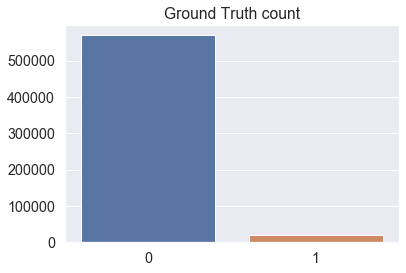

In [41]:
import seaborn as sns

y = y_train.value_counts().values
sns.barplot(y_train.value_counts().index, y)

plt.title('Ground Truth count')

y_train.value_counts()

In [42]:
#train_merged.dtypes
num_obj_types = 0
for column_name in X_train.columns:
    if X_train[column_name].dtype=='object':
        num_obj_types += 1
        print(column_name)
        
print("No of object types to be encoded :", num_obj_types, "out of", len(X_train.columns))

ProductCD
card4
card6
P_emaildomain
R_emaildomain
M1
M2
M3
M4
M5
M6
M7
M8
M9
id_12
id_15
id_28
id_29
id_31
id_35
id_36
id_37
id_38
DeviceType
No of object types to be encoded : 24 out of 316


In [43]:
X_train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_19,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,86400,68.5,W,13926,-999.0,150.0,discover,142.0,credit,315,...,-999.0,-999.0,-999,-999,-999,-999,-999,-999,-999,desktop
2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325,...,-999.0,-999.0,-999,-999,-999,-999,-999,-999,-999,desktop
2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330,...,-999.0,-999.0,-999,-999,-999,-999,-999,-999,-999,desktop
2987003,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476,...,-999.0,-999.0,-999,-999,-999,-999,-999,-999,-999,desktop
2987004,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420,...,542.0,144.0,New,NotFound,samsung browser 6.2,T,F,T,T,mobile


In [44]:
# shape does not include "TranscationID", because it is used for index_col
X_train.shape, X_test.shape, y_train.shape

((590540, 316), (506691, 316), (590540,))

In [45]:
X_train.iloc[0:10]['card4']

TransactionID
2987000      discover
2987001    mastercard
2987002          visa
2987003    mastercard
2987004    mastercard
2987005          visa
2987006          visa
2987007          visa
2987008          visa
2987009    mastercard
Name: card4, dtype: object

In [46]:
# Label Encoding before model training
for index in X_train.columns:
    if X_train[index].dtype=='object' or X_test[index].dtype=='object': 
        # print(X_train[index])
        # Encode labels with value between 0 and n_classes-1
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[index].values) + list(X_test[index].values))
        X_train[index] = lbl.transform(list(X_train[index].values))
        X_test[index] = lbl.transform(list(X_test[index].values))  

In [47]:
# Encoded and transformed
X_train.iloc[0:10]['card4']

TransactionID
2987000    2
2987001    3
2987002    4
2987003    3
2987004    3
2987005    4
2987006    4
2987007    4
2987008    4
2987009    3
Name: card4, dtype: int64

In [59]:
# Standardize features by removing the mean and scaling to unit variance
#X_train = std_scaler.fit_transform(X_train)
#X_test = std_scaler.fit_transform(X_test)

###  If XGBClassifier model exists, load it

In [57]:
import os.path
retrieve_xgbc_file = './datasets/IEEEFraudDetection/XGBClassifier_model_pickle'

if os.path.exists(retrieve_xgbc_file):
    #xgb_Classifier.save_model and load_model give an "le" error when trying to obtain score
    # Unpickling saved binary file if exist so that training do not need to done
    loaded_XGBClassifier = load_classifier_from_picklefile(retrieve_xgbc_file)
    print("Unpickling existing XGBClassifier model...")
    print("Loaded Classifier :\n", loaded_XGBClassifier)
    print("with type\n", type(loaded_XGBClassifier))

Unpickling existing XGBClassifier model...
Loaded Classifier :
 XGBClassifier(alpha=4, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.1,
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=-999, n_estimators=500, n_jobs=4,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)
with type
 <class 'xgboost.sklearn.XGBClassifier'>


In [58]:
loaded_XGBClassifier.score(X_train, y_train)

# 0.9897060317675348 has roc_auc of # (array([0.85256255, 0.74023   , 0.80202556]), 0.798272703167005)

0.9897652995563383

In [59]:
X_train.shape, X_test.shape

((590540, 310), (506691, 310))

# Expensive operations

In [68]:
# Using Cross Validation to check the performance
from sklearn.model_selection import cross_val_score

# Takes more than 1.2 hours; n_jobs = -1 using all processors
# Score of 0.9897652995563383 for dropping columns with missing data of more than 77% except "DeviceInfo"
# and filled with highest value
# roc_auc of (array([0.83323631, 0.74587757, 0.79986377]), 0.7929925507730294) with fillnans in section 1

loaded_XGBClassifier_auc_scores = cross_val_score(loaded_XGBClassifier, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1)
loaded_XGBClassifier_auc_scores, loaded_XGBClassifier_auc_scores.mean()

(array([0.83323631, 0.74587757, 0.79986377]), 0.7929925507730294)

In [69]:
xgb_predictions = loaded_XGBClassifier.predict_proba(X_test)
create_file_for_submission("./datasets/IEEEFraudDetection/loaded_simple_xgboost.csv", xgb_predictions)

# Classifiers and Predictions
## (1) XGradient Boost Classifier

In [49]:
X_train.shape, X_test.shape

((590540, 316), (506691, 316))

### Else create XGBClassifier model and save it

In [50]:
# Approx. 1.5 hours on 8 x i9 Cores
xgb_Classifier = xgb.XGBClassifier(n_estimators=500, n_jobs=-1, max_depth=9, learning_rate=0.05,
                                   subsample=0.9, colsample_bytree=0.9, missing=-999, 
                                   gamma = 0.1, alpha = 4)

xgb_Classifier.fit(X_train, y_train)

XGBClassifier(alpha=4, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.1,
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=-999, n_estimators=500, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

In [51]:
# Returns the mean accuracy on the given test data and labels
xgb_Classifier.score(X_train, y_train)

# 0.9897669929217326 for full dataset
# 0.9893317980153757 for dropping 51 columns
# 0.9891607681105429 for dropping 'TransactionDT'
# 0.9888322552240323 for dropping columns with missing data of more than 75%
# 0.989768686287127 for dropping columns with missing data of more than 77%

# 0.9897652995563383 for dropping columns with missing data of more than 77% except "DeviceInfo"
# and filled with highest value

# 0.9895519355166458 for full dataset will fill in values for ['D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'addr1', 'addr2']

0.989460493785349

In [52]:
xgb_predictions = xgb_Classifier.predict_proba(X_test)
# xgb_predictions.shape gives (506691, 2)
# xgb_predictions[0:2, 1] gives 2 values in the second column

# Pickling files
print("Pickling XGBClassifier model...")
filename = './datasets/IEEEFraudDetection/XGBClassifier_model_pickle'
save_classifier_to_picklefile(filename, xgb_Classifier)

Pickling XGBClassifier model...


In [53]:
create_file_for_submission("./datasets/IEEEFraudDetection/XGBClassifier_partial_dataset.csv", xgb_predictions)

In [54]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, xgb_Classifier.predict_proba(X_train)[:, 1])
print("AUC score :", auc(false_positive_rate, true_positive_rate))
print("ROC_AUC score :", roc_auc_score(y_train, xgb_Classifier.predict_proba(X_train)[:, 1]))

# 0.9886906321399489
# 0.9879135083040298

AUC score : 0.9879128832280477
ROC_AUC score : 0.9879128832280477


In [55]:
X_train.shape, X_test.shape

((590540, 316), (506691, 316))

# GridSearchCV for best parameters

In [57]:
X_train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_19,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,86400,68.5,4,13926,-999.0,150.0,2,142.0,2,315,...,-999.0,-999.0,0,0,0,0,0,0,0,1
2987001,86401,29.0,4,2755,404.0,150.0,3,102.0,2,325,...,-999.0,-999.0,0,0,0,0,0,0,0,1
2987002,86469,59.0,4,4663,490.0,150.0,4,166.0,3,330,...,-999.0,-999.0,0,0,0,0,0,0,0,1
2987003,86499,50.0,4,18132,567.0,150.0,3,117.0,3,476,...,-999.0,-999.0,0,0,0,0,0,0,0,1
2987004,86506,50.0,1,4497,514.0,150.0,3,102.0,2,420,...,542.0,144.0,2,2,162,2,1,2,2,2


In [58]:
# Search the best combination of hyperparameter values
# ** This will take more than 5+ hours **
from sklearn.model_selection import GridSearchCV

# loaded_XGBClassifier.get_params().keys()
kfold=2

colsample_bytrees = [0.9, 0.95]
gammas = [0.01, 0.1] #, 0.1, 1]
learning_rates = [0.05, 0.10]
max_depths = [9, 10]
missings = [-999]
n_estimators = [200, 500]
subsamples = [0.9, 0.95]

xgb_Classifier_param_grid = {#'colsample_bytree': colsample_bytrees,
                             'gamma': gammas,
                             #'learning_rate': learning_rates,
                             #'max_depth': max_depths,
                             #'missing': missings,
                             'n_estimators': n_estimators,
                             #'subsample': subsamples
                            }

# Tuning the param for GridSearch and performance has been increased to approx. x% 
grid_search = GridSearchCV(xgb_Classifier, xgb_Classifier_param_grid,
                           cv=kfold, scoring="roc_auc", n_jobs=-1, verbose = 1) # n_jobs= 4

grid_search.fit(X_train, y_train)
grid_search.best_params_

#[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
#[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed: 26.1min remaining: 26.1min
#[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 55.2min finished
#{'gamma': 0.01, 'n_estimators': 500}

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed: 26.1min remaining: 26.1min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 55.2min finished


{'gamma': 0.01, 'n_estimators': 500}

In [59]:
# Using GridSearchCV to obtain final model with best estimator
best_xgb_classifier_model = grid_search.best_estimator_
best_xgb_classifier_model

XGBClassifier(alpha=4, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.01,
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=-999, n_estimators=500, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

In [60]:
best_xgb_classifier_model.score(X_train, y_train)

0.9897077251329292

In [62]:
best_xgb_classifier_predictions = best_xgb_classifier_model.predict_proba(X_test)

# Pickling files
print("Pickling Best XGBClassifier model...")
filename = './datasets/IEEEFraudDetection/Best_XGBClassifier_model_pickle'
save_classifier_to_picklefile(filename, best_xgb_classifier_model)

Pickling Best XGBClassifier model...


In [63]:
create_file_for_submission("./datasets/IEEEFraudDetection/BestXGBClassifier_partial_dataset.csv", best_xgb_classifier_predictions)

In [64]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, best_xgb_classifier_model.predict_proba(X_train)[:, 1])
print("AUC score :", auc(false_positive_rate, true_positive_rate))
print("ROC_AUC score :", roc_auc_score(y_train, best_xgb_classifier_model.predict_proba(X_train)[:, 1]))

# AUC score : 0.9885925180550428

AUC score : 0.9885925180550428
ROC_AUC score : 0.9885925180550428


In [69]:
best_xgb_classifier_predict_proba_results = best_xgb_classifier_model.predict_proba(X_train)

best_xgb_classifier_predict_proba_results

array([[0.9743466 , 0.02565344],
       [0.98938525, 0.01061478],
       [0.9937539 , 0.00624608],
       ...,
       [0.9962339 , 0.0037661 ],
       [0.9773295 , 0.02267051],
       [0.99662256, 0.00337741]], dtype=float32)

In [70]:
# Analyze the Best Models and their Errors
feature_importances = grid_search.best_estimator_.feature_importances_
print("Length of features", len(feature_importances), "with values :")

feature_importances

Length of features 316 with values :


array([1.7198517e-03, 1.9953463e-03, 4.6202401e-03, 2.0405175e-03,
       2.3232566e-03, 4.3439995e-03, 1.8521360e-03, 1.9795701e-03,
       4.1847508e-03, 2.0225975e-03, 4.1388511e-03, 1.8784525e-03,
       2.2537792e-03, 3.3883229e-03, 6.8874988e-03, 2.4766002e-03,
       3.0661218e-03, 3.0275797e-03, 2.9489524e-03, 2.8358423e-03,
       7.8179212e-03, 6.4155166e-03, 2.2764518e-03, 2.3099417e-03,
       3.2810618e-03, 1.2547484e-02, 4.7132890e-03, 1.0465549e-02,
       2.1757064e-03, 3.6533633e-03, 2.1842455e-03, 1.8786384e-03,
       1.2622327e-03, 1.7930324e-03, 8.9066988e-04, 1.9203277e-03,
       0.0000000e+00, 1.9758693e-03, 1.6491619e-03, 1.8821423e-03,
       1.5645621e-03, 1.3278237e-03, 2.0462510e-03, 0.0000000e+00,
       1.5103087e-03, 2.2809124e-03, 2.5016258e-03, 3.0885078e-03,
       2.5505333e-03, 9.6316898e-04, 1.5614126e-03, 2.8489039e-03,
       8.6931128e-04, 1.7227902e-03, 1.3607609e-03, 1.4901073e-03,
       1.6795192e-03, 1.3253756e-03, 1.2988534e-03, 1.4980106e

## (2) XGradient Boost Random Forest Classifier

###  If XGBRFClassifier model exists, load it

In [ ]:
retrieve_xgbrfc_file = './datasets/IEEEFraudDetection/XGBRFClassifier_model_pickle'

if os.path.exists(retrieve_xgbrfc_file):
    # Unpickling saved binary file if exist so that training do not need to done
    loaded_XGBRFClassifier = load_classifier_from_picklefile(retrieve_xgbrfc_file)
    print("Unpickling existing XGBClassifier model...")
    print("Loaded Classifier :\n", loaded_XGBRFClassifier)
    print("with type\n", type(loaded_XGBRFClassifier))

In [ ]:
loaded_XGBRFClassifier.score(X_train, y_train)

# 0.9757188336099164

In [ ]:
xgbrf_predictions = loaded_XGBRFClassifier.predict_proba(X_test)
create_file_for_submission("./datasets/IEEEFraudDetection/loaded_simple_xgbrf.csv", xgbrf_predictions)

### Else create XGBRFClassifier model and save it

In [ ]:
xgb_RFClassifier = xgb.XGBRFClassifier(n_estimators=500,
                        n_jobs=4,
                        max_depth=9,
                        learning_rate=0.05,
                        subsample=0.9,
                        colsample_bytree=0.9,
                        missing=-999)

# scale_pos_weight=1
xgb_RFClassifier.fit(X_train, y_train)

In [ ]:
xgb_RFClassifier.score(X_train, y_train)

In [ ]:
xgbrf_predictions = xgb_RFClassifier.predict_proba(X_test)

# Pickling files
print("Pickling XGBRandomForestClassifier model...")
filename = './datasets/IEEEFraudDetection/XGBRFClassifier_model_pickle'
save_classifier_to_picklefile(filename, xgb_RFClassifier)

In [ ]:
create_file_for_submission("./datasets/IEEEFraudDetection/XGBRFClassifier.csv", xgbrf_predictions)

## (3) Bagging Classifier

In [ ]:
from sklearn.ensemble import 
from sklearn.tree import DecisionTreeClassifier

bag_Classifier = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=500,
                                   max_samples=50000, bootstrap=True, n_jobs=-1, random_state=42)

In [ ]:
bag_Classifier.fit(X_train, y_train)
bag_predictions = bag_Classifier.predict(X_test)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, bag_predictions.shape

In [ ]:
bag_Classifier.score(X_train, y_train)

# 0.9781183323737596 partial dataset
# 0.9780556778541674 full dataset

In [ ]:
classifier_predictions = np.reshape(bag_predictions, (bag_predictions.shape[0], 1))
classifier_index = np.reshape(X_test.index, (X_test.index.shape[0], 1))

print("The reshape of Prediction numpy array : ", classifier_predictions.shape)
classifier_predicted_results = np.concatenate((classifier_index, classifier_predictions), axis=1)

classifier_predicted_results.shape

In [ ]:
create_file_for_submission("./datasets/IEEEFraudDetection/Bag_Classifier_partial_dataset.csv", classifier_predicted_results)

## (4) SVM Classifiers

In [ ]:
from sklearn.svm import LinearSVC

svm_classifier = LinearSVC(class_weight='balanced')
svm_classifier.fit(X_train, y_train)

In [ ]:
# Using Cross Validation to check the performance of Support Vector Machine
svm_scores = cross_val_score(svm_classifier, X_train, y_train, cv=3)
svm_scores.mean()

In [ ]:
svm_predictions = svm_classifier.predict(X_test)
svm_predictions.shape

In [ ]:
X_test.index.shape

In [ ]:
classifier_predictions = np.reshape(svm_predictions, (svm_predictions.shape[0], 1))
classifier_index = np.reshape(X_test.index, (X_test.index.shape[0], 1))

print("The reshape of Prediction numpy array : ", classifier_predictions.shape)
classifier_predicted_results = np.concatenate((classifier_index, classifier_predictions), axis=1)

classifier_predicted_results.shape

In [ ]:
create_file_for_submission("./datasets/IEEEFraudDetection/svm_classifier.csv", classifier_predicted_results)

# Ensemble Learning : Voting Classifier

In [ ]:
import os.path
retrieve_sftvc_file = './datasets/IEEEFraudDetection/SoftVotingClassifier_model_pickle'

if os.path.exists(retrieve_sftvc_file):
    #xgb_Classifier.save_model and load_model give an "le" error when trying to obtain score
    # Unpickling saved binary file if exist so that training do not need to done
    loaded_SoftVoteClassifier = load_classifier_from_picklefile(retrieve_sftvc_file)
    print("Unpickling existing SoftVoteClassifier model...")
    print("Loaded Classifier :\n", loaded_SoftVoteClassifier)
    print("with type\n", type(loaded_SoftVoteClassifier))

In [ ]:
loaded_SoftVoteClassifier.score(X_train, y_train)

# 0.9894046127273343

In [ ]:
sftvc_predictions = loaded_SoftVoteClassifier.predict_proba(X_test)
create_file_for_submission("./datasets/IEEEFraudDetection/loaded_simple_sftvc.csv", sftvc_predictions)

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_classifier = VotingClassifier(
    estimators=[('XGB_classifier', loaded_XGBClassifier),
                ('XGB_RF_classifier', loaded_XGBRFClassifier),],
    n_jobs=4,
    voting='soft') 

voting_classifier.fit(X_train, y_train)

voting_classifier.get_params() # gives parameters of the VotingClassifier

In [ ]:
voting_classifier.score(X_train, y_train)

# 0.9894046127273343

In [ ]:
# Pickling files
print("Pickling VotingClassifier model...")
filename = './datasets/IEEEFraudDetection/SoftVotingClassifier_model_pickle'
save_classifier_to_picklefile(filename, voting_classifier)

In [ ]:
voting_classifier_auc_scores = cross_val_score(voting_classifier, X_train, y_train, cv=3, scoring='roc_auc')
voting_classifier_auc_scores, voting_classifier_auc_scores.mean()

# (array([0.87149802, 0.74444081, 0.78814395]), 0.8013609304639683)

In [ ]:
# Compute probabilities of possible outcomes for samples
voting_classifier_predictions = voting_classifier.predict_proba(X_test)

voting_classifier_predictions.shape

In [ ]:
print("Sample of Predictions")
print("SoftVoting :\n", voting_classifier_predictions[10:20, 1])
print("XGBRF : \n", xgbrf_predictions[10:20, 1])
print("XGB : \n", xgb_predictions[10:20, 1])

In [ ]:
create_file_for_submission("./datasets/IEEEFraudDetection/Soft_Voting_Classifier.csv", voting_classifier_predictions)

In [ ]:
#print ("Predicted {} frauds".format(int([voting_classifier_predictions['isFraud']==1].sum())))
print("Predicted {} frauds".format(int((voting_classifier_predictions[:, 1]>0.5).sum())))

In [ ]:
# Search the best combination of hyperparameter values
from sklearn.model_selection import GridSearchCV

# loaded_XGBClassifier.get_params().keys()
kfold=3

colsample_bytrees = [0.9, 0.95]
gammas = [0.001, 0.01, 0.1, 1]
learning_rates = [0.05, 0.10]
max_depths = [9, 10]
missings = [0, -999]
n_estimators = [100, 200]
subsamples = [0.9, 0.95]

voting_classifier_param_grid = {'colsample_bytree': colsample_bytrees,
                                'gamma': gammas,
                                'learning_rate': learning_rates,
                                'max_depth': max_depths,
                                'missing': missings,
                                'n_estimators': n_estimators,
                                'subsample': subsamples
                               }

# Tuning the param for GridSearch and performance has been increased to approx. x% 
grid_search = GridSearchCV(voting_classifier, voting_classifier_param_grid,
                           cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

grid_search.fit(X_train, y_train)
grid_search.best_params_

# Submissions

- kaggle competitions submit -c ieee-fraud-detection -f submission.csv -m "Message"
- Submitted Public score of 0.9366 at position 321 with XGBClassifier with mean score of 98.971%
- Submitted Public score of 0.8543 with scaled features for XGBClassifier with mean score of 98.964%
- Submitted Public score of 0.8757 with XGBRFClassifier having mean score of 97.572%
- Submitted Public score of 0.5240 with balanced weight SVM Linear Classifier with mean cv score of 96.437%.
- Submitted Public score of 0.9375 at position 334 using Soft Voting Classifier with XGBC and XGBRFC gives a mean score of 98.940%.
- Submitted Public score of <B>0.9376 at position 343</B> using XGBClassifier with partial dataset and score of 98.933%.
<BR>(Suspect over fitting with skewed dataset)

# Helper Codes

In [31]:
print(train_merged.columns)
print(imputer_list)

Index(['isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1',
       'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=433)
['D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'addr1', 'addr2']


In [36]:
pd.Series(np.intersect1d(pd.Series(train_merged.columns), pd.Series(selected_features_above_threshold)))

0      DeviceInfo
1            V138
2            V139
3            V140
4            V141
          ...    
111         id_27
112         id_30
113         id_32
114         id_33
115         id_34
Length: 116, dtype: object

In [ ]:
cat_cols = ['ProductCD',
            'card1', 'card2', 'card3', 'card4','card5', 'card6',
            'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain',
            'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
            'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21',
            'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31',
            'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
            'DeviceType', 'DeviceInfo']

len(cat_cols)

In [ ]:
row_idx = 0
value = 4685.0
found_pos_idx = 0

for c in X_train['C1']:
    row_idx = row_idx + 1
    if c == value:
        found_pos_idx = row_idx
        #print("Found", value)

print(found_pos_idx, "of", row_idx)

c=X_train['C1']
c[found_pos_idx-1:found_pos_idx].values

In [ ]:
# Check if value exists in pandas data frame
if getattr(X_train, 'C1').isin(['4685.0']).any():
    print("Found 4685.0")

c = X_train['C1']
c[0:10].values

In [ ]:
#train_merged.dtypes
# Before LabelEncoder
X_train['DeviceType'].head()

In [ ]:
lbl = preprocessing.LabelEncoder()
lbl.fit(list(X_train['DeviceType'].values) + list(X_test['DeviceType'].values))
X_train['DeviceType'] = lbl.transform(list(X_train['DeviceType'].values))

In [ ]:
# After LabelEncoder
X_train['DeviceType'].head()

In [ ]:
# Correlation Matrix
corr_matrix = train_merged.corr()
correlation_fraud = corr_matrix['isFraud'].sort_values(ascending=False)

total_num_features = len(correlation_fraud)
selected_num_features = 0
for ctr in range(total_num_features): # cols loop
    if correlation_fraud[ctr] > -0.04 and correlation_fraud[ctr] < 0.04:
        selected_num_features += 1
        print("'" + correlation_fraud.index[ctr] + "',") #, " :", correlation_fraud[ctr])

print("Total selected features :", selected_num_features)

In [ ]:
id_ctr = list(range(12, 39)) # Range from 12 - 38
id_list = []
for num in id_ctr:
    numStr = "id_" + str(num) 
    id_list.append(numStr)

print(id_list)

for identifier in id_list:
    df = pd.DataFrame(train_merged[identifier], index = train_merged.index) # TransactionID is the index
    # Getting the unqiue values
    df = df.nunique()
    #print (df)

In [ ]:
import multiprocessing as mp
import math
from sklearn.model_selection import cross_val_score
 
pool = mp.Pool(processes=8)
# pool.apply
loaded_XGBClassifier_auc_scores = [pool.apply_async(cross_val_score(loaded_XGBClassifier, X_train, y_train, cv=3, scoring='roc_auc'))]

print(loaded_XGBClassifier_auc_scores)